Now that I've selected and confirmed all the appropriate variables, the next step is to investigate the data and metadata, and ensure I can harmonise the G0G1 variables with the previous G227 and G228 variables.

## Set up

In [ ]:
import banksia as bk
import polars as pl
from pathlib import Path
from fastcore.utils import *
import fastcore.all as fc, numpy as np, matplotlib.pyplot as plt
import re, math, itertools, functools, types, typing, dataclasses, collections, regex, time, asyncio
from dialoghelper import *

In [ ]:
pl.Config.set_fmt_str_lengths(150)  # or whatever length you want

polars.config.Config

In [ ]:
INPUT = Path("../data/input")
OUTPUT = Path("../data/output")

In [ ]:
vl = pl.read_excel("../value_labels.xlsx")
vl.head()

Could not determine dtype for column 3, falling back to string


Could not determine dtype for column 20, falling back to string


Could not determine dtype for column 25, falling back to string


Could not determine dtype for column 26, falling back to string


Could not determine dtype for column 27, falling back to string


Could not determine dtype for column 28, falling back to string


Could not determine dtype for column 29, falling back to string


Could not determine dtype for column 30, falling back to string


Could not determine dtype for column 31, falling back to string


Could not determine dtype for column 32, falling back to string


SPSS .SAV file (03.12.25),Gen (03.12.25),Actual Variable Name,Harmonised Variable Name,Variable label (03.12.25),Suggested Variable Label (defaulted to most common variable label for this variable name),Harmonised by,Harmonised Comments,Harmonised Status,Variable base name (03.12.25),Concatenated Value Labels (03.12.25),Standardised Concatenated Value Labels,RODES Variable Name,RODES Variable Label,RODES Value Labels,RODES Variable ID,RODES Variable Category,RODES Variable Subcategory,Suggested Category (Used by Ray to load into RODES),Suggested SUBCategory (Used by Ray to load into RODES)2,Category - work,Type (03.12.25),Meas. Level (03.12.25),Format (03.12.25),Width (03.12.25),Decimals (03.12.25),In Master Var. List (03.12.25),__UNNAMED__31,__UNNAMED__32
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str
"""G0G1_Q.sav""","""G0G1""","""G0G1_BRC_D1""",null,"""Breast cancer: Daughter1""","""Breast cancer: Daughter1""","""Matt""","""WIP""","""In Progress""","""BRC_D1""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""0=""No"";1=""Yes"";2=""Don't know"";8=""N/A"";9=""Missing""""","""""","""""","""""",null,"""""","""""","""Biological measurements""",null,null,"""Numeric""","""Scale""","""F8""",8,null,null,null,null
"""G0G1_Q.sav""","""G0G1""","""G0G1_BRC_D2""",null,"""Breast cancer: Daughter2""","""Breast cancer: Daughter2""","""Matt""","""WIP""","""In Progress""","""BRC_D2""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""0=""No"";1=""Yes"";2=""Don't know"";8=""N/A"";9=""Missing""""","""""","""""","""""",null,"""""","""""","""Biological measurements""",null,null,"""Numeric""","""Scale""","""F8""",8,null,null,null,null
"""G0G1_Q.sav""","""G0G1""","""G0G1_BRC_D3""",null,"""Breast cancer: Daughter3""","""Breast cancer: Daughter3""","""Matt""","""WIP""","""In Progress""","""BRC_D3""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""0=""No"";1=""Yes"";2=""Don't know"";8=""N/A"";9=""Missing""""","""""","""""","""""",null,"""""","""""","""Biological measurements""",null,null,"""Numeric""","""Scale""","""F8""",8,null,null,null,null
"""G0G1_Q.sav""","""G0G1""","""G0G1_BRC_D4""",null,"""Breast cancer: Daughter4""","""Breast cancer: Daughter4""","""Matt""","""WIP""","""In Progress""","""BRC_D4""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""0=""No"";1=""Yes"";2=""Don't know"";8=""N/A"";9=""Missing""""","""""","""""","""""",null,"""""","""""","""Biological measurements""",null,null,"""Numeric""","""Scale""","""F8""",8,null,null,null,null
"""G0G1_Q.sav""","""G0G1""","""G0G1_BRC_D5""",null,"""Breast cancer: Daughter5""","""Breast cancer: Daughter5""","""Matt""","""WIP""","""In Progress""","""BRC_D5""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""0=""No"";1=""Yes"";2=""Don't know"";8=""N/A"";9=""Missing""""","""""","""""","""""",null,"""""","""""","""Biological measurements""",null,null,"""Numeric""","""Scale""","""F8""",8,null,null,null,null


In [ ]:
vl = vl.rename({"SPSS .SAV file (03.12.25)": 'file', 'Actual Variable Name': 'var'}).select('file', 'var').filter(pl.col('file').is_not_null())
vl.head()

file,var
str,str
"""G0G1_Q.sav""","""G0G1_BRC_D1"""
"""G0G1_Q.sav""","""G0G1_BRC_D2"""
"""G0G1_Q.sav""","""G0G1_BRC_D3"""
"""G0G1_Q.sav""","""G0G1_BRC_D4"""
"""G0G1_Q.sav""","""G0G1_BRC_D5"""


In [ ]:
vl = vl.group_by('file').agg(pl.col('var'))
vl

file,var
str,list[str]
"""G227_PA.sav""","[""G227_BROC"", ""G227_BROC_COM"", … ""G227_SIS3_OC""]"
"""G0G1_Q.sav""","[""G0G1_BRC_D1"", ""G0G1_BRC_D2"", … ""G0G1_OVCA_S5""]"
"""G228_MainQandRQ.sav""","[""G228_BROC"", ""G228_MA1_BRC"", … ""G228_SIS3_OC_AGE""]"


For the next step, we'll merge the datasets and metadata together, and begin exploring subsets of these variables

In [ ]:
def merge(vl: pl.DataFrame, dir: str|Path=INPUT) -> tuple[pl.DataFrame, pl.DataFrame]:
    dfs, ms = [], []
    for file, cols in vl.rows():
        df, m = bk.read_sav(dir/file, usecols=["ID"] + cols)
        dfs.append(df), ms.append(m)
    df = pl.concat(dfs, how="align")
    m = pl.concat(ms, how="vertical").filter(pl.col("Variable").ne("ID")).with_columns(basename=pl.col("Variable").str.slice(5))
    return df, m

## Family History

### Screenshots of questions from proforma

G227

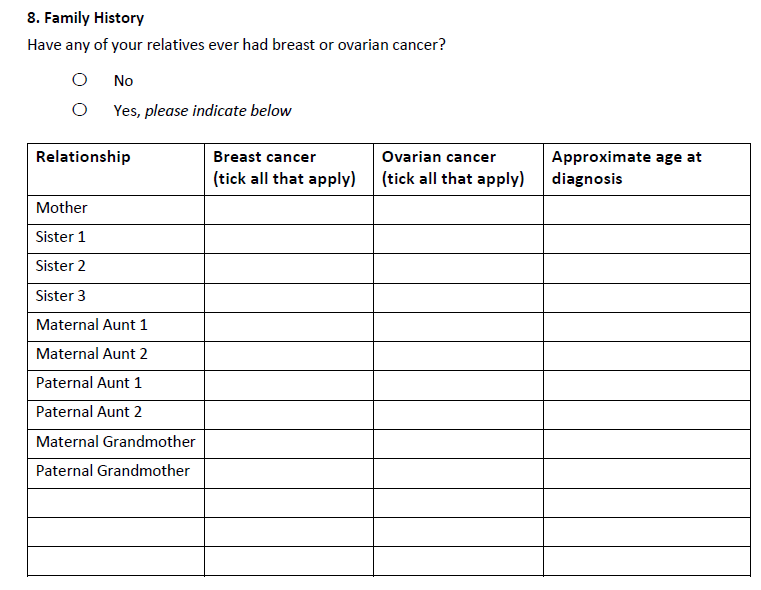
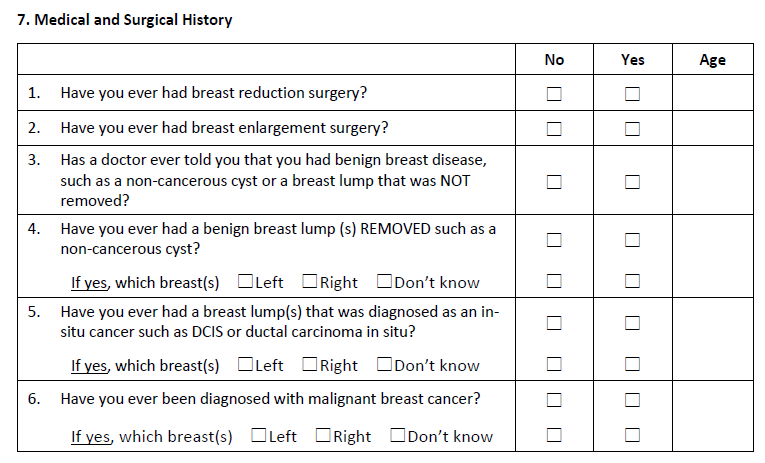

G228

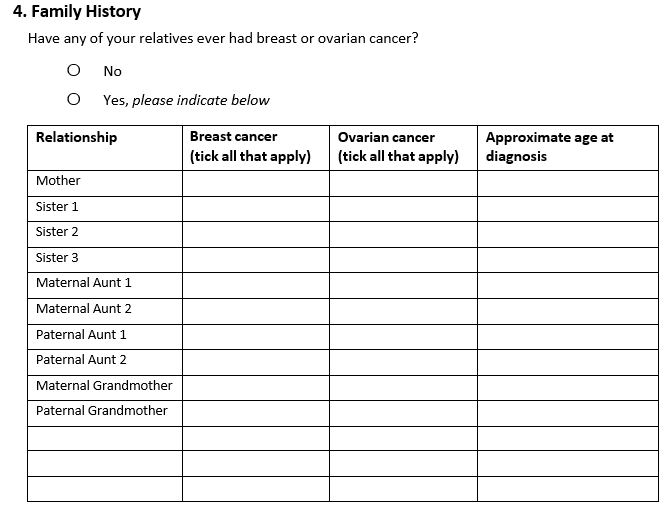
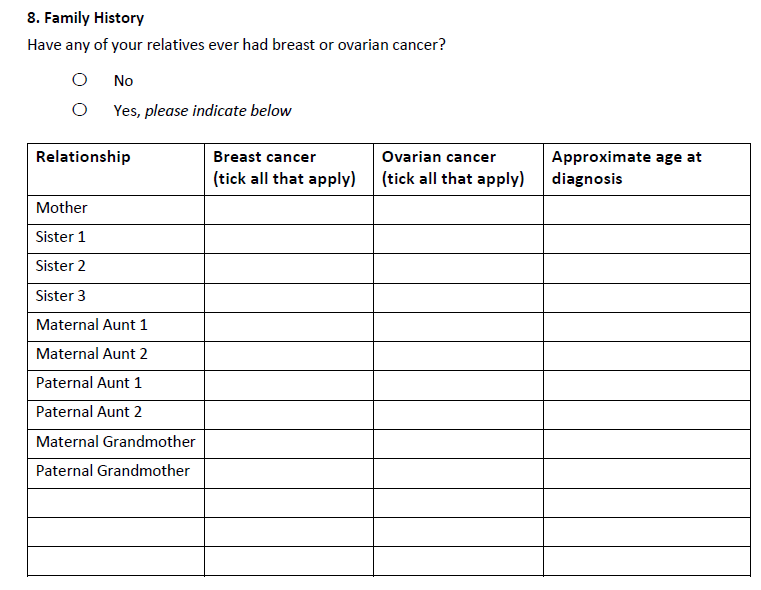
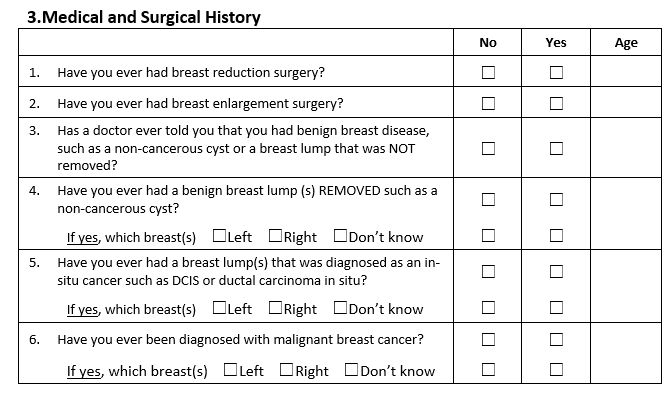

G0G1

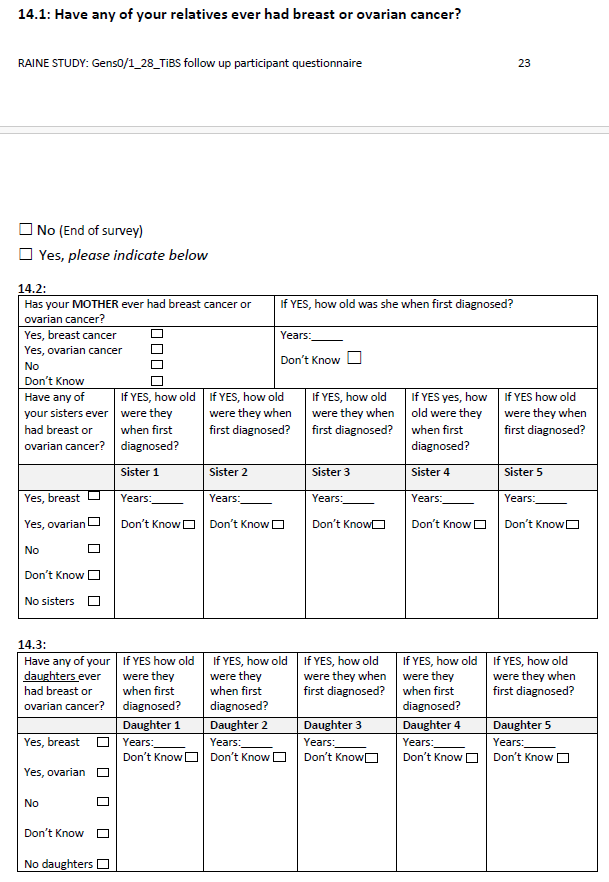
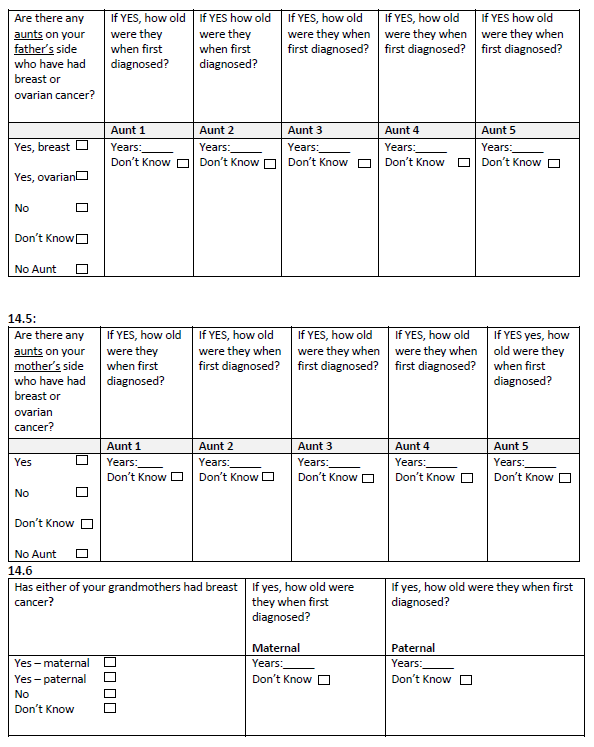
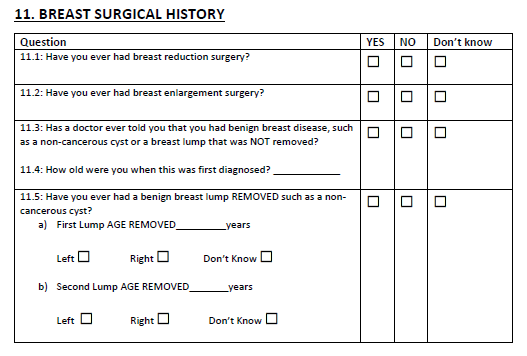
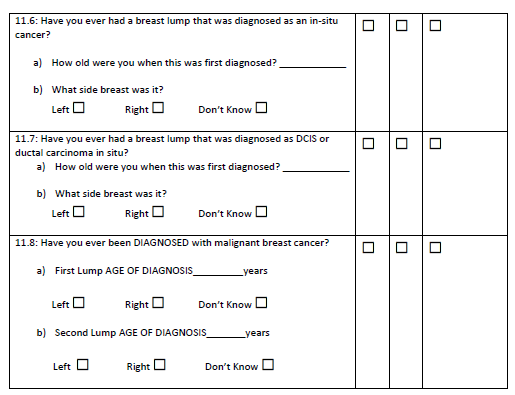

### Investigating the data

In [ ]:
df, m = merge(vl)

In [ ]:
df.head()

ID,G227_BROC,G227_BROC_COM,G227_MO_BRC,G227_MO_OC,G227_MO_AGE,G227_SIS1_BRC,G227_SIS1_OC,G227_SIS1_AGE,G227_SIS2_BRC,G227_SIS2_OC,G227_SIS2_AGE,G227_SIS3_BRC,G227_SIS3_OC,G227_SIS3_AGE,G227_MA1_BRC,G227_MA1_OC,G227_MA1_AGE,G227_MA2_BRC,G227_MA2_OC,G227_MA2_AGE,G227_PA1_BRC,G227_PA1_OC,G227_PA1_AGE,G227_PA2_BRC,G227_PA2_OC,G227_PA2_AGE,G227_MG_BRC,G227_MG_OC,G227_MG_AGE,G227_PG_BRC,G227_PG_OC,G227_PG_AGE,G0G1_FH_BROV,G0G1_BRC_MO,G0G1_OVC_MO,G0G1_BRCA_MO,…,G228_OR1_BRC_OTH,G228_OR2_BRC_OTH,G228_MO_BRC_AGE,G228_SIS1_BRC_AGE,G228_SIS2_BRC_AGE,G228_SIS3_BRC_AGE,G228_MA1_BRC_AGE,G228_MA2_BRC_AGE,G228_PA1_BRC_AGE,G228_PA2_BRC_AGE,G228_MG_BRC_AGE,G228_PG_BRC_AGE,G228_OR1_BRC_AGE,G228_OR2_BRC_AGE,G228_MO_OC,G228_SIS1_OC,G228_SIS2_OC,G228_SIS3_OC,G228_MA1_OC,G228_MA2_OC,G228_PA1_OC,G228_PA2_OC,G228_MG_OC,G228_PG_OC,G228_OR1_OC,G228_OR1_OC_OTH,G228_MO_OC_AGE,G228_SIS1_OC_AGE,G228_SIS2_OC_AGE,G228_SIS3_OC_AGE,G228_MA1_OC_AGE,G228_MA2_OC_AGE,G228_PA1_OC_AGE,G228_PA2_OC_AGE,G228_MG_OC_AGE,G228_PG_OC_AGE,G228_OR1_OC_AGE
f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
301.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,8.0,8.0,888.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
501.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,8.0,8.0,888.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1201.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,8.0,8.0,888.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1401.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,8.0,8.0,888.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1501.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,0.0,888.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [ ]:
m.head()

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_BROC""","""Any relatives EVER had Breast or Ovarian cancer""","""Numeric""",3,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""BROC"""
"""G227_BROC_COM""","""Any relatives ever had breast or ovarian cancer? - comment""","""String""",8,0,"""nominal""",null,"""BROC_COM"""
"""G227_MO_BRC""","""Breast cancer: Mother""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_BRC"""
"""G227_MO_OC""","""Ovarian cancer: Mother""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_OC"""
"""G227_MO_AGE""","""Breast or ovarian cancer - Age at diagnosis - mother""","""Numeric""",11,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MO_AGE"""


In [ ]:
def value_counts(df: pl.DataFrame, cols: str | list[str]) -> pl.DataFrame:
    """Get value counts for multiple columns."""
    return df.select(cols).unpivot().group_by(["variable", "value"]).len().pivot(on="variable", index="value", values="len").sort("value")

#### Any relatives ever had breast or ovarian cancer?

In [ ]:
pattern = r"^.*(BROC|FH_BROV)$"

In [ ]:
m.filter(pl.col("Variable").str.contains(pattern))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_BROC""","""Any relatives EVER had Breast or Ovarian cancer""","""Numeric""",3,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""BROC"""
"""G0G1_FH_BROV""","""Breast or ovarian cancer in relatives""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";3=""Yes, in distant relative eg. cousin"";8=""Not applicable"";9=""Not stated""""","""FH_BROV"""
"""G228_BROC""","""Any relatives EVER had Breast or Ovarian cancer""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""BROC"""


In [ ]:
value_counts(df, pattern)

value,G228_BROC,G227_BROC,G0G1_FH_BROV
f64,u32,u32,u32
null,3005,2899,2868
-99.0,7,2,null
0.0,290,369,340
1.0,139,171,196
2.0,null,null,17
3.0,null,null,13
9.0,null,null,7


Changes:
- rename `G0G1_FH_BROV` to `G0G1_BROC_1`
- recode 9 to -99
- update label to be consistent with other `BROC` variables
- update field values to remove 8 and change 9 to -99

#### Mother

In [ ]:
pattern = r"^.*(MO_BRC|MO_OC|BRC_MO|OVC_MO)$"

In [ ]:
m.filter(pl.col("Variable").str.contains(pattern))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_MO_BRC""","""Breast cancer: Mother""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_BRC"""
"""G227_MO_OC""","""Ovarian cancer: Mother""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_OC"""
"""G0G1_BRC_MO""","""Breast cancer: Mother""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MO"""
"""G0G1_OVC_MO""","""Ovarian cancer: Mother""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MO"""
"""G228_MO_BRC""","""Breast cancer: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_BRC"""
"""G228_MO_OC""","""Ovarian cancer: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_OC"""


In [ ]:
value_counts(df, pattern)

value,G0G1_OVC_MO,G227_MO_BRC,G0G1_BRC_MO,G228_MO_OC,G227_MO_OC,G228_MO_BRC
f64,u32,u32,u32,u32,u32,u32
null,2868,2899,2868,3005,2899,3005
-99.0,null,2,null,130,2,118
-88.0,null,369,null,290,369,290
0.0,139,148,144,7,161,4
1.0,17,23,59,9,10,24
2.0,12,null,13,null,null,null
8.0,344,null,344,null,null,null
9.0,61,null,13,null,null,null


Changes:
- rename `G0G1_BRC_MO` to `G0G1_MO_BRC` and `G0G1_OVC_MO` to `G0G1_MO_OC`
- update label
- update field values
- recode 8 to -88 and 9 to -99

In [ ]:
cols = ["G0G1_BRCA_MO", "G227_MO_AGE", "G0G1_OVCA_MO", "G228_MO_BRC_AGE", "G228_MO_OC_AGE"]
m.filter(pl.col("Variable").is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_MO_AGE""","""Breast or ovarian cancer - Age at diagnosis - mother""","""Numeric""",11,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MO_AGE"""
"""G0G1_BRCA_MO""","""Breast cancer: Age diagnosed: Mother""","""Numeric""",8,0,"""scale""",null,"""BRCA_MO"""
"""G0G1_OVCA_MO""","""Ovarian cancer: Age diagnosed: Mother""","""Numeric""",8,0,"""scale""",null,"""OVCA_MO"""
"""G228_MO_BRC_AGE""","""Breast cancer- Age diagnosed: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MO_BRC_AGE"""
"""G228_MO_OC_AGE""","""Ovarian cancer- Age diagnosed: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MO_OC_AGE"""


In [ ]:
value_counts(df, cols)

value,G228_MO_BRC_AGE,G227_MO_AGE,G0G1_BRCA_MO,G228_MO_OC_AGE,G0G1_OVCA_MO
f64,u32,u32,u32,u32,u32
null,3005,2899,2868,3005,2868
-99.0,null,5,null,null,null
-88.0,null,507,null,null,null
16.0,null,1,null,null,null
18.0,1,null,null,null,null
…,…,…,…,…,…
87.0,null,null,1,null,null
88.0,null,null,1,null,null
89.0,null,null,1,null,null


Changes:
- rename `G0G1_BRCA_MO` to `G0G1_MO_BRC_AGE` and `G0G1_OVCA_MO` to `G0G1_MO_OC_AGE`
- update label
- update field values
- recode 888 to -88 and 999 to -99 (for `G228_MO_OC_AGE`, `G228_MO_BRC_AGE`, `G0G1_BRCA_MO`, `G0G1_OVCA_MO`)

In [ ]:
def new_var(person: str, pattern: str):
    add_msg(f"#### {person} ever had breast or ovarian cancer?")
    add_msg(f"pattern = r'^.*({pattern})$'", msg_type='code')
    add_msg(f"m.filter(pl.col('Variable').str.contains({pattern}))", msg_type='code')
    add_msg(f"value_counts(df, {pattern})", msg_type='code')
    add_msg("""Changes:

    - rename
    - update label
    - update field values
    - recode""")

#### Daughters

In [ ]:
cols = """G0G1_BRC_D1
G0G1_BRC_D2
G0G1_BRC_D3
G0G1_BRC_D4
G0G1_BRC_D5
G0G1_OVC_D1
G0G1_OVC_D2
G0G1_OVC_D3
G0G1_OVC_D4
G0G1_OVC_D5""".splitlines()

cols[:5]

['G0G1_BRC_D1', 'G0G1_BRC_D2', 'G0G1_BRC_D3', 'G0G1_BRC_D4', 'G0G1_BRC_D5']

In [ ]:
m.filter(pl.col('Variable').is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G0G1_BRC_D1""","""Breast cancer: Daughter1""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_D1"""
"""G0G1_BRC_D2""","""Breast cancer: Daughter2""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_D2"""
"""G0G1_BRC_D3""","""Breast cancer: Daughter3""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_D3"""
"""G0G1_BRC_D4""","""Breast cancer: Daughter4""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_D4"""
"""G0G1_BRC_D5""","""Breast cancer: Daughter5""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_D5"""
"""G0G1_OVC_D1""","""Ovarian cancer: Daughter1""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_D1"""
"""G0G1_OVC_D2""","""Ovarian cancer: Daughter2""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_D2"""
"""G0G1_OVC_D3""","""Ovarian cancer: Daughter3""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_D3"""
"""G0G1_OVC_D4""","""Ovarian cancer: Daughter4""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_D4"""


In [ ]:
value_counts(df, cols)

value,G0G1_OVC_D1,G0G1_OVC_D4,G0G1_OVC_D2,G0G1_BRC_D3,G0G1_BRC_D2,G0G1_BRC_D4,G0G1_OVC_D5,G0G1_BRC_D5,G0G1_BRC_D1,G0G1_OVC_D3
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2868,2868,2868,2868,2868
0.0,113,10,60,34,85,15,3,4,148,24
1.0,1,null,null,1,1,null,null,null,5,2
2.0,3,null,1,null,1,null,null,null,3,null
8.0,404,511,459,526,474,545,519,556,404,495
9.0,52,52,53,12,12,13,51,13,13,52


In [ ]:
cols = """G0G1_BRCA_D1
G0G1_BRCA_D2
G0G1_BRCA_D3
G0G1_BRCA_D4
G0G1_BRCA_D5
G0G1_OVCA_D1
G0G1_OVCA_D2
G0G1_OVCA_D3
G0G1_OVCA_D4
G0G1_OVCA_D5""".splitlines()

cols[:5]

['G0G1_BRCA_D1',
 'G0G1_BRCA_D2',
 'G0G1_BRCA_D3',
 'G0G1_BRCA_D4',
 'G0G1_BRCA_D5']

In [ ]:
m.filter(pl.col('Variable').is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G0G1_BRCA_D1""","""Breast cancer: Age diagnosed: Daughter1""","""Numeric""",8,0,"""scale""",null,"""BRCA_D1"""
"""G0G1_BRCA_D2""","""Breast cancer: Age diagnosed: Daughter2""","""Numeric""",8,0,"""scale""",null,"""BRCA_D2"""
"""G0G1_BRCA_D3""","""Breast cancer: Age diagnosed: Daughter3""","""Numeric""",8,0,"""scale""",null,"""BRCA_D3"""
"""G0G1_BRCA_D4""","""Breast cancer: Age diagnosed: Daughter4""","""Numeric""",8,0,"""scale""",null,"""BRCA_D4"""
"""G0G1_BRCA_D5""","""Breast cancer: Age diagnosed: Daughter5""","""Numeric""",8,0,"""scale""",null,"""BRCA_D5"""
"""G0G1_OVCA_D1""","""Ovarian cancer: Age diagnosed: Daughter1""","""Numeric""",8,0,"""scale""",null,"""OVCA_D1"""
"""G0G1_OVCA_D2""","""Ovarian cancer: Age diagnosed: Daughter2""","""Numeric""",8,0,"""scale""",null,"""OVCA_D2"""
"""G0G1_OVCA_D3""","""Ovarian cancer: Age diagnosed: Daughter3""","""Numeric""",8,0,"""scale""",null,"""OVCA_D3"""
"""G0G1_OVCA_D4""","""Ovarian cancer: Age diagnosed: Daughter4""","""Numeric""",8,0,"""scale""",null,"""OVCA_D4"""


In [ ]:
value_counts(df, cols)

value,G0G1_BRCA_D3,G0G1_BRCA_D1,G0G1_BRCA_D5,G0G1_OVCA_D4,G0G1_OVCA_D3,G0G1_OVCA_D1,G0G1_OVCA_D2,G0G1_BRCA_D2,G0G1_OVCA_D5,G0G1_BRCA_D4
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2868,2868,2868,2868,2868
28.0,null,null,null,null,1,null,null,null,null,null
31.0,null,null,null,null,null,1,null,null,null,null
36.0,null,null,null,null,1,null,null,null,null,null
42.0,null,1,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…
53.0,null,2,null,null,null,null,null,null,null,null
59.0,null,null,null,null,null,null,null,1,null,null
71.0,null,1,null,null,null,null,null,null,null,null


#### Sisters

In [ ]:
cols = """G0G1_BRC_S1
G0G1_BRC_S2
G0G1_BRC_S3
G0G1_BRC_S4
G0G1_BRC_S5
G227_SIS1_BRC
G227_SIS2_BRC
G227_SIS3_BRC
G228_SIS1_BRC
G228_SIS2_BRC
G228_SIS3_BRC""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRC_S1,G0G1_BRC_S2,G0G1_BRC_S3,G0G1_BRC_S4,G0G1_BRC_S5,G227_SIS1_BRC,G227_SIS2_BRC,G227_SIS3_BRC,G228_SIS1_BRC,G228_SIS2_BRC,G228_SIS3_BRC
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,2899,3005,3005,3005
-99.0,null,null,null,null,null,2,2,2,139,140,140
-88.0,null,null,null,null,null,369,369,369,290,290,290
0.0,97,48,26,14,7,170,171,171,6,6,6
1.0,29,6,2,1,null,1,null,null,1,null,null
2.0,4,2,1,1,1,null,null,null,null,null,null
8.0,431,502,530,544,553,null,null,null,null,null,null
9.0,12,15,14,13,12,null,null,null,null,null,null


In [ ]:
cols = """G0G1_OVC_S1
G0G1_OVC_S2
G0G1_OVC_S3
G0G1_OVC_S4
G0G1_OVC_S5
G227_SIS1_OC
G227_SIS2_OC
G227_SIS3_OC
G228_SIS1_OC
G228_SIS2_OC
G228_SIS3_OC""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_OVC_S1,G0G1_OVC_S2,G0G1_OVC_S3,G0G1_OVC_S4,G0G1_OVC_S5,G227_SIS1_OC,G227_SIS2_OC,G227_SIS3_OC,G228_SIS1_OC,G228_SIS2_OC,G228_SIS3_OC
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,2899,3005,3005,3005
-99.0,null,null,null,null,null,2,2,2,140,140,141
-88.0,null,null,null,null,null,369,369,369,290,290,290
0.0,91,42,21,10,5,171,171,171,5,5,5
1.0,4,null,null,null,null,null,null,null,1,1,null
2.0,9,3,2,1,1,null,null,null,null,null,null
8.0,431,490,511,523,528,null,null,null,null,null,null
9.0,38,38,39,39,39,null,null,null,null,null,null


In [ ]:
cols = """G0G1_BRCA_S1
G0G1_BRCA_S2
G0G1_BRCA_S3
G0G1_BRCA_S4
G0G1_BRCA_S5
G227_SIS1_AGE
G227_SIS2_AGE
G227_SIS3_AGE
G228_SIS1_BRC_AGE
G228_SIS2_BRC_AGE
G228_SIS3_BRC_AGE
""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRCA_S1,G0G1_BRCA_S2,G0G1_BRCA_S3,G0G1_BRCA_S4,G0G1_BRCA_S5,G227_SIS1_AGE,G227_SIS2_AGE,G227_SIS3_AGE,G228_SIS1_BRC_AGE,G228_SIS2_BRC_AGE,G228_SIS3_BRC_AGE
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,2899,3005,3005,3005
-99.0,null,null,null,null,null,2,2,2,null,null,null
-88.0,null,null,null,null,null,539,540,540,null,null,null
28.0,null,null,null,null,null,null,null,null,1,null,null
35.0,null,null,1,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…
68.0,1,null,null,null,null,null,null,null,null,null,null
70.0,1,null,null,null,null,null,null,null,null,null,null
80.0,2,null,null,null,null,null,null,null,null,null,null


In [ ]:
cols = """G0G1_OVCA_S1
G0G1_OVCA_S2
G0G1_OVCA_S3
G0G1_OVCA_S4
G0G1_OVCA_S5
G227_SIS1_AGE
G227_SIS2_AGE
G227_SIS3_AGE
G228_SIS1_OC_AGE
G228_SIS2_OC_AGE
G228_SIS3_OC_AGE""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_OVCA_S1,G0G1_OVCA_S2,G0G1_OVCA_S3,G0G1_OVCA_S4,G0G1_OVCA_S5,G227_SIS1_AGE,G227_SIS2_AGE,G227_SIS3_AGE,G228_SIS1_OC_AGE,G228_SIS2_OC_AGE,G228_SIS3_OC_AGE
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,2899,3005,3005,3005
-99.0,null,null,null,null,null,2,2,2,null,null,null
-88.0,null,null,null,null,null,539,540,540,null,null,null
27.0,null,null,null,null,null,null,null,null,null,1,null
30.0,null,null,null,null,null,null,null,null,1,null,null
…,…,…,…,…,…,…,…,…,…,…,…
50.0,1,null,null,null,null,null,null,null,null,null,null
58.0,1,null,null,null,null,null,null,null,null,null,null
60.0,1,null,null,null,null,null,null,null,null,null,null


#### Maternal Aunts

In [ ]:
cols = """G0G1_BRC_MA1
G0G1_BRC_MA2
G0G1_BRC_MA3
G0G1_BRC_MA4
G0G1_BRC_MA5
G228_MA1_BRC
G227_MA1_BRC
G228_MA2_BRC
G227_MA2_BRC""".splitlines()

In [ ]:
m.filter(pl.col('Variable').is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_MA1_BRC""","""Breast cancer: Maternal Aunt1""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA1_BRC"""
"""G227_MA2_BRC""","""Breast cancer: Maternal Aunt2""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA2_BRC"""
"""G0G1_BRC_MA1""","""Breast cancer: Maternal Aunt1""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MA1"""
"""G0G1_BRC_MA2""","""Breast cancer: Maternal Aunt2""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MA2"""
"""G0G1_BRC_MA3""","""Breast cancer: Maternal Aunt3""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MA3"""
"""G0G1_BRC_MA4""","""Breast cancer: Maternal Aunt4""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MA4"""
"""G0G1_BRC_MA5""","""Breast cancer: Maternal Aunt5""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MA5"""
"""G228_MA1_BRC""","""Breast cancer: Maternal Aunt1""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA1_BRC"""
"""G228_MA2_BRC""","""Breast cancer: Maternal Aunt2""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA2_BRC"""


In [ ]:
value_counts(df, cols)

value,G228_MA2_BRC,G227_MA2_BRC,G0G1_BRC_MA3,G227_MA1_BRC,G0G1_BRC_MA5,G0G1_BRC_MA2,G0G1_BRC_MA1,G0G1_BRC_MA4,G228_MA1_BRC
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,3005,2899,2868,2899,2868,2868,2868,2868,3005
-99.0,137,2,null,2,null,null,null,null,108
-88.0,290,369,null,369,null,null,null,null,290
0.0,6,168,25,135,6,37,75,13,5
1.0,3,3,1,36,1,15,35,null,33
2.0,null,null,10,null,5,22,29,8,null
8.0,null,null,525,null,547,486,422,539,null
9.0,null,null,12,null,14,13,12,13,null


In [ ]:
cols = """G0G1_OVC_MA1
G0G1_OVC_MA2
G0G1_OVC_MA3
G0G1_OVC_MA4
G0G1_OVC_MA5
G228_MA1_OC
G227_MA1_OC
G228_MA2_OC
G227_MA2_OC""".splitlines()

In [ ]:
m.filter(pl.col('Variable').is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_MA1_OC""","""Ovarian cancer: Maternal Aunt1""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA1_OC"""
"""G227_MA2_OC""","""Ovarian cancer: Maternal Aunt2""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA2_OC"""
"""G0G1_OVC_MA1""","""Ovarian cancer: Maternal Aunt1""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MA1"""
"""G0G1_OVC_MA2""","""Ovarian cancer: Maternal Aunt2""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MA2"""
"""G0G1_OVC_MA3""","""Ovarian cancer: Maternal Aunt3""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MA3"""
"""G0G1_OVC_MA4""","""Ovarian cancer: Maternal Aunt4""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MA4"""
"""G0G1_OVC_MA5""","""Ovarian cancer: Maternal Aunt5""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MA5"""
"""G228_MA1_OC""","""Ovarian cancer: Maternal Aunt1""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA1_OC"""
"""G228_MA2_OC""","""Ovarian cancer: Maternal Aunt2""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MA2_OC"""


In [ ]:
value_counts(df, cols)

value,G0G1_OVC_MA1,G0G1_OVC_MA2,G0G1_OVC_MA3,G227_MA1_OC,G0G1_OVC_MA4,G227_MA2_OC,G228_MA2_OC,G0G1_OVC_MA5,G228_MA1_OC
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2899,2868,2899,3005,2868,3005
-99.0,null,null,null,2,null,2,141,null,136
-88.0,null,null,null,369,null,369,290,null,290
0.0,71,36,19,165,11,169,5,6,5
1.0,9,2,2,6,1,2,null,null,5
2.0,27,21,10,null,8,null,null,6,null
8.0,422,470,498,null,509,null,null,517,null
9.0,44,44,44,null,44,null,null,44,null


In [ ]:
cols = """G227_MA1_AGE
G227_MA2_AGE
G228_MA1_BRC_AGE
G228_MA1_OC_AGE
G228_MA2_BRC_AGE
G228_MA2_OC_AGE
G0G1_BRCA_MA1
G0G1_BRCA_MA2
G0G1_BRCA_MA3
G0G1_BRCA_MA4
G0G1_BRCA_MA5
G0G1_OVCA_MA1
G0G1_OVCA_MA2
G0G1_OVCA_MA3
G0G1_OVCA_MA4
G0G1_OVCA_MA5""".splitlines()

In [ ]:
m.filter(pl.col('Variable').is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_MA1_AGE""","""Breast or ovarian cancer - Age at diagnosis - maternal aunt 1""","""Numeric""",11,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MA1_AGE"""
"""G227_MA2_AGE""","""Breast or ovarian cancer - Age at diagnosis - maternal aunt 2""","""Numeric""",11,0,"""scale""",null,"""MA2_AGE"""
"""G0G1_BRCA_MA1""","""Breast cancer: Age diagnosed: Maternal Aunt1""","""Numeric""",8,0,"""scale""",null,"""BRCA_MA1"""
"""G0G1_BRCA_MA2""","""Breast cancer: Age diagnosed: Maternal Aunt2""","""Numeric""",8,0,"""scale""",null,"""BRCA_MA2"""
"""G0G1_BRCA_MA3""","""Breast cancer: Age diagnosed: Maternal Aunt3""","""Numeric""",8,0,"""scale""",null,"""BRCA_MA3"""
…,…,…,…,…,…,…,…
"""G0G1_OVCA_MA5""","""Ovarian cancer: Age diagnosed: Maternal Aunt5""","""Numeric""",8,0,"""scale""",null,"""OVCA_MA5"""
"""G228_MA1_BRC_AGE""","""Breast cancer- Age diagnosed: Maternal Aunt1""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MA1_BRC_AGE"""
"""G228_MA2_BRC_AGE""","""Breast cancer- Age diagnosed: Maternal Aunt2""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MA2_BRC_AGE"""


In [ ]:
value_counts(df, cols)

value,G0G1_OVCA_MA3,G0G1_BRCA_MA2,G227_MA2_AGE,G228_MA1_BRC_AGE,G227_MA1_AGE,G0G1_BRCA_MA1,G0G1_BRCA_MA3,G0G1_OVCA_MA1,G0G1_BRCA_MA4,G228_MA1_OC_AGE,G0G1_BRCA_MA5,G228_MA2_BRC_AGE,G228_MA2_OC_AGE,G0G1_OVCA_MA2,G0G1_OVCA_MA4,G0G1_OVCA_MA5
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2899,3005,2899,2868,2868,2868,2868,3005,2868,3005,3005,2868,2868,2868
-99.0,null,null,null,null,5,null,null,null,null,null,null,null,null,null,null,null
-88.0,null,null,null,null,498,null,null,null,null,null,null,null,null,null,null,null
27.0,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null
30.0,null,null,null,null,2,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
72.0,null,null,null,null,null,null,1,null,null,null,null,null,null,null,null,null
75.0,null,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null
84.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


#### Paternal Aunts

In [ ]:
cols = """G0G1_BRC_PA1
G0G1_BRC_PA2
G0G1_BRC_PA3
G0G1_BRC_PA4
G0G1_BRC_PA5
G227_PA1_BRC
G227_PA2_BRC
G228_PA1_BRC
G228_PA2_BRC""".splitlines()

In [ ]:
m.filter(pl.col('Variable').is_in(cols))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_PA1_BRC""","""Breast cancer: Paternal Aunt1""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PA1_BRC"""
"""G227_PA2_BRC""","""Breast cancer: Paternal Aunt2""","""Numeric""",8,2,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PA2_BRC"""
"""G0G1_BRC_PA1""","""Breast cancer: Paternal Aunt1""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_PA1"""
"""G0G1_BRC_PA2""","""Breast cancer: Paternal Aunt2""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_PA2"""
"""G0G1_BRC_PA3""","""Breast cancer: Paternal Aunt3""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_PA3"""
"""G0G1_BRC_PA4""","""Breast cancer: Paternal Aunt4""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_PA4"""
"""G0G1_BRC_PA5""","""Breast cancer: Paternal Aunt5""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_PA5"""
"""G228_PA1_BRC""","""Breast cancer: Paternal Aunt1""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PA1_BRC"""
"""G228_PA2_BRC""","""Breast cancer: Paternal Aunt2""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PA2_BRC"""


In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRC_PA1,G0G1_BRC_PA2,G0G1_BRC_PA3,G0G1_BRC_PA4,G0G1_BRC_PA5,G227_PA1_BRC,G227_PA2_BRC,G228_PA1_BRC,G228_PA2_BRC
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,3005,3005
-99.0,null,null,null,null,null,2,2,124,139
-88.0,null,null,null,null,null,369,369,290,290
0.0,68,33,13,7,7,152,171,6,6
1.0,20,1,1,null,null,19,null,16,1
2.0,42,19,6,4,4,null,null,null,null
8.0,428,504,537,546,546,null,null,null,null
9.0,15,16,16,16,16,null,null,null,null


In [ ]:
cols = """G0G1_OVC_PA1
G0G1_OVC_PA2
G0G1_OVC_PA3
G0G1_OVC_PA4
G0G1_OVC_PA5
G227_PA1_OC
G227_PA2_OC
G228_PA1_OC
G228_PA2_OC
""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_OVC_PA1,G0G1_OVC_PA2,G0G1_OVC_PA3,G0G1_OVC_PA4,G0G1_OVC_PA5,G227_PA1_OC,G227_PA2_OC,G228_PA1_OC,G228_PA2_OC
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,3005,3005
-99.0,null,null,null,null,null,2,2,141,141
-88.0,null,null,null,null,null,369,369,290,290
0.0,57,23,11,5,5,169,171,5,5
1.0,6,1,null,null,null,2,null,null,null
2.0,37,17,5,4,4,null,null,null,null
8.0,428,486,511,518,518,null,null,null,null
9.0,45,46,46,46,46,null,null,null,null


In [ ]:
cols = """G0G1_BRCA_PA1
G0G1_BRCA_PA2
G0G1_BRCA_PA3
G0G1_BRCA_PA4
G0G1_BRCA_PA5
G227_PA1_AGE
G227_PA2_AGE
G228_PA1_BRC_AGE
G228_PA2_BRC_AGE""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRCA_PA1,G0G1_BRCA_PA2,G0G1_BRCA_PA3,G0G1_BRCA_PA4,G0G1_BRCA_PA5,G227_PA1_AGE,G227_PA2_AGE,G228_PA1_BRC_AGE,G228_PA2_BRC_AGE
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2899,2899,3005,3005
-99.0,null,null,null,null,null,6,2,null,null
-88.0,null,null,null,null,null,521,540,null,null
32.0,null,null,null,null,null,1,null,null,null
33.0,null,null,null,null,null,1,null,null,null
…,…,…,…,…,…,…,…,…,…
75.0,1,null,null,null,null,null,null,null,null
78.0,1,null,null,null,null,null,null,null,null
80.0,1,null,null,null,null,null,null,null,null


In [ ]:
cols = """G0G1_OVCA_PA1
G0G1_OVCA_PA2
G0G1_OVCA_PA3
G0G1_OVCA_PA4
G0G1_OVCA_PA5
G228_PA1_OC_AGE
G228_PA2_OC_AGE""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_OVCA_PA1,G0G1_OVCA_PA2,G0G1_OVCA_PA3,G0G1_OVCA_PA4,G0G1_OVCA_PA5,G228_PA1_OC_AGE,G228_PA2_OC_AGE
f64,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,3005,3005
35.0,null,1,null,null,null,null,null
50.0,1,null,null,null,null,null,null
60.0,2,null,null,null,null,null,null
75.0,1,null,null,null,null,null,null
76.0,1,null,null,null,null,null,null
888.0,522,526,527,527,527,295,295
999.0,46,46,46,46,46,141,141


#### Maternal Grandmother

In [ ]:
cols = """G0G1_BRC_MG
G0G1_OVC_MG
G227_MG_BRC
G227_MG_OC
G228_MG_BRC
G228_MG_OC""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRC_MG,G0G1_OVC_MG,G227_MG_BRC,G227_MG_OC,G228_MG_BRC,G228_MG_OC
f64,u32,u32,u32,u32,u32,u32
null,2868,2868,2899,2899,3005,3005
-99.0,null,null,2,3,101,129
-88.0,null,null,369,369,290,290
0.0,126,98,113,155,5,5
1.0,22,3,58,15,40,12
2.0,63,62,null,null,null,null
8.0,344,344,null,null,null,null
9.0,18,66,null,null,null,null


In [ ]:
cols = """G0G1_BRCA_MG
G0G1_OVCA_MG
G227_MG_AGE
G228_MG_BRC_AGE
G228_MG_OC_AGE""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRCA_MG,G0G1_OVCA_MG,G227_MG_AGE,G228_MG_BRC_AGE,G228_MG_OC_AGE
f64,u32,u32,u32,u32,u32
null,2868,2868,2899,3005,3005
-99.0,null,null,12,null,null
-88.0,null,null,469,null,null
25.0,null,null,1,null,null
30.0,1,null,3,1,1
…,…,…,…,…,…
86.0,null,null,1,null,null
89.0,null,null,1,null,null
90.0,null,null,null,null,1


#### Paternal Grandmother

In [ ]:
cols = """G0G1_BRC_PG
G0G1_OVC_PG
G227_PG_BRC
G227_PG_OC
G228_PG_BRC
G228_PG_OC""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRC_PG,G0G1_OVC_PG,G227_PG_BRC,G227_PG_OC,G228_PG_BRC,G228_PG_OC
f64,u32,u32,u32,u32,u32,u32
null,2868,2868,2899,2899,3005,3005
-99.0,36,75,2,2,118,135
-88.0,344,344,369,369,290,290
0.0,99,85,134,166,2,6
1.0,24,2,37,5,26,5
2.0,70,67,null,null,null,null


In [ ]:
cols = """G0G1_BRCA_PG
G0G1_OVCA_PG
G227_PG_AGE
G228_PG_BRC_AGE
G228_PG_OC_AGE""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G0G1_BRCA_PG,G0G1_OVCA_PG,G227_PG_AGE,G228_PG_BRC_AGE,G228_PG_OC_AGE
f64,u32,u32,u32,u32,u32
null,2868,2868,2899,3005,3005
-99.0,null,null,16,null,null
-88.0,null,null,499,null,null
19.0,null,null,1,null,null
35.0,null,null,1,null,null
…,…,…,…,…,…
80.0,1,null,1,2,null
93.0,1,null,null,null,null
95.0,null,null,1,null,null


#### Other Relatives (G228 Only)

In [ ]:
cols = """G228_OR1_BRC
G228_OR1_OC
G228_OR2_BRC""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G228_OR1_BRC,G228_OR1_OC,G228_OR2_BRC
f64,u32,u32,u32
null,3005,3005,3005
-99.0,424,432,432
0.0,3,3,3
1.0,9,1,1


In [ ]:
cols = """G228_OR1_BRC_OTH
G228_OR1_OC_OTH
G228_OR2_BRC_OTH""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G228_OR1_BRC_OTH,G228_OR1_OC_OTH,G228_OR2_BRC_OTH
str,u32,u32,u32
null,2536,2536,2536
"""""",469,469,469
"""Brother""",1,null,null
"""Father's aunt""",null,null,1
"""Half sister paternal""",1,null,null
…,…,…,…
"""Paternal Great Aunts""",1,null,null
"""Paternal cousin""",null,1,null
"""cousin""",1,null,null


In [ ]:
cols = """G228_OR1_BRC_AGE
G228_OR1_OC_AGE
G228_OR2_BRC_AGE""".splitlines()

In [ ]:
value_counts(df, cols).select("value", *cols)

value,G228_OR1_BRC_AGE,G228_OR1_OC_AGE,G228_OR2_BRC_AGE
f64,u32,u32,u32
null,3005,3005,3005
22.0,null,1,null
25.0,1,null,null
34.0,1,null,null
35.0,1,null,null
…,…,…,…
58.0,1,null,null
60.0,1,null,null
85.0,null,null,1


In [ ]:
df.select("G227_BROC_COM").unique()

G227_BROC_COM
str
"""Relatives could be interpred as extended family or distant relatives ex. Cousins (the variable created during clean-up)"""
""""""
null


How can I check there are no non-ASCII and no non-printable characters in the values for "G227_BROC_COM"?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! There are a couple of approaches you could take:

1. **Regex approach**: Use a pattern like `[^\x20-\x7E]` which matches anything *not* in the printable ASCII range (space through tilde).

2. **Python string method**: Use `str.isprintable()` combined with an ASCII check via `str.isascii()`.

For Polars, the regex approach with `str.contains()` would be cleanest. You could filter for rows where the pattern matches (i.e., rows that *have* non-printable or non-ASCII characters).

Would you like to try writing that filter, or would you like me to show you how?

In [ ]:
assert df.filter(pl.col("G227_BROC_COM").str.contains(r"[^\x20-\x7E]")).height == 0

### Overview of changes to implement

#### Explore `changes`

In [ ]:
changes = pl.read_excel("../changes.xlsx")
changes.head()

file,old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values,recode,status
str,str,str,str,str,str,str,str,str
"""G0G1_Q.sav""","""G0G1_BRC_D1""","""G0G1_D1_BRC_1""","""Breast cancer: Daughter1""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D2""","""G0G1_D2_BRC_1""","""Breast cancer: Daughter2""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D3""","""G0G1_D3_BRC_1""","""Breast cancer: Daughter3""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D4""","""G0G1_D4_BRC_1""","""Breast cancer: Daughter4""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D5""","""G0G1_D5_BRC_1""","""Breast cancer: Daughter5""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""


In [ ]:
changes.item(0, 6)

'-99="Missing";-88="N/A";0="No";1="Yes";2="Don\'t know"'

In [ ]:
changes.item(0, 7)

'{8: -88, 9: -99}'

How can I convert '{8: -88, 9: -99}' to {8: -88, 9: -99}?
I know I can use eval(), but are there are downsides to this, and are there other methods?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Here are the main options:

**1. `eval()`** — Works but has security risks if the string comes from untrusted sources (it can execute arbitrary code).

**2. `ast.literal_eval()`** — The safer alternative. It only evaluates literals (strings, numbers, dicts, lists, tuples, booleans, None), so it won't execute arbitrary code. This is usually the recommended approach.

**3. `json.loads()`** — Won't work directly here because JSON requires double quotes for keys and strings, and your keys are integers without quotes.

Since your `changes.xlsx` is your own file and the format is Python dict literals, `ast.literal_eval()` is the best choice — it's safe and handles your format directly:

```python
import ast
ast.literal_eval('{8: -88, 9: -99}')
```

Would you like to try it out?

Let's filter for variables that need to be updated in some way, whether it's renaming the variable name, updating the label/field values, or recoding values.

In [ ]:
filtered_changes = changes.filter(pl.col("new_var_name").is_not_null() | pl.col("new_var_label").is_not_null() | pl.col("new_field_values").is_not_null() | pl.col("recode").is_not_null())
filtered_changes.head()

file,old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values,recode,status
str,str,str,str,str,str,str,str,str
"""G0G1_Q.sav""","""G0G1_BRC_D1""","""G0G1_D1_BRC_1""","""Breast cancer: Daughter1""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D2""","""G0G1_D2_BRC_1""","""Breast cancer: Daughter2""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D3""","""G0G1_D3_BRC_1""","""Breast cancer: Daughter3""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D4""","""G0G1_D4_BRC_1""","""Breast cancer: Daughter4""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""
"""G0G1_Q.sav""","""G0G1_BRC_D5""","""G0G1_D5_BRC_1""","""Breast cancer: Daughter5""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""{8: -88, 9: -99}""","""complete"""


From this table, we want to identify the changes to make, both for the data and metadata, and subsequently create functions to apply the necessary transformations.

For the changes in data, we'll want to know the file, old_var_name, new_var_name, and the values to recode.  
For changes in metadata, we want to know the file, old_var_name, new_var_name, and then the final var_label and field_values, which will entail taking the new values if they exist, or else referring to the old values.

#### Changes in data

In [ ]:
row = changes.row(0, named=True)
row

{'file': 'G0G1_Q.sav',
 'old_var_name': 'G0G1_BRC_D1',
 'new_var_name': 'G0G1_D1_BRC_1',
 'old_var_label': 'Breast cancer: Daughter1',
 'new_var_label': None,
 'old_field_values': '0="No";1="Yes";2="Don\'t know";8="Not applicable";9="Not stated"',
 'new_field_values': '-99="Missing";-88="N/A";0="No";1="Yes";2="Don\'t know"',
 'recode': '{8: -88, 9: -99}',
 'status': 'complete'}

In [ ]:
rename = {row.get('old_var_name'): row.get('new_var_name')} if row.get('new_var_name') is not None else {}
rename

{'G0G1_BRC_D1': 'G0G1_D1_BRC_1'}

In [ ]:
import ast

In [ ]:
ast.literal_eval(row.get('recode', '{}'))

{8: -88, 9: -99}

In [ ]:
d = dict(
    file=row.get('file'), 
    rename={row.get('old_var_name'): row.get('new_var_name')} if row.get('new_var_name') is not None else {},
    recode=ast.literal_eval(row.get('recode', '{}')))
d

{'file': 'G0G1_Q.sav',
 'rename': {'G0G1_BRC_D1': 'G0G1_D1_BRC_1'},
 'recode': {8: -88, 9: -99}}

Perhaps rather than including 'file' as a parameter, we should first be grouping by the file first, and *then* determining the changes to be made for that specific file.

In [ ]:
d = dict(
    var=row.get('old_var_name'),
    rename=row.get('new_var_name'),
    recode=ast.literal_eval(row.get('recode', '{}')))
d

{'var': 'G0G1_BRC_D1', 'rename': 'G0G1_D1_BRC_1', 'recode': {8: -88, 9: -99}}

This structure makes more sense, because *all* changes need to tie back to the `var`, rename will be None if it's not to be renamed, and recode will be an empty dict if there's no recoding to be done.

In [ ]:
data_changes = filtered_changes.filter(pl.col('file').eq('G0G1_Q.sav')).select('old_var_name', 'new_var_name', 'recode')
data_changes

old_var_name,new_var_name,recode
str,str,str
"""G0G1_BRC_D1""","""G0G1_D1_BRC_1""","""{8: -88, 9: -99}"""
"""G0G1_BRC_D2""","""G0G1_D2_BRC_1""","""{8: -88, 9: -99}"""
"""G0G1_BRC_D3""","""G0G1_D3_BRC_1""","""{8: -88, 9: -99}"""
"""G0G1_BRC_D4""","""G0G1_D4_BRC_1""","""{8: -88, 9: -99}"""
"""G0G1_BRC_D5""","""G0G1_D5_BRC_1""","""{8: -88, 9: -99}"""
…,…,…
"""G0G1_OVCA_S1""","""G0G1_SIS1_OC_AGE""","""{888: -88, 999: -99}"""
"""G0G1_OVCA_S2""","""G0G1_SIS2_OC_AGE""","""{888: -88, 999: -99}"""
"""G0G1_OVCA_S3""","""G0G1_SIS3_OC_AGE""","""{888: -88, 999: -99}"""


We created `d` above by creating a dictionary for the desired parameters based on a single row.
What kind of structure/representation would make the most sense to convert the information from this dataframe into a function that applies the desired transformations to our actual data?

For example, we probably want an overall single dictionary for all the renaming variables that we can pass to `df.rename(renames)`, and then a single function call which applies all the recoding to the respective values, as concisely as possible.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! Here's what I'd suggest:

**For renaming:**
A single flat dict works perfectly:
```python
renames = {'G0G1_BRC_D1': 'G0G1_D1_BRC_1', 'G0G1_BRC_D2': 'G0G1_D2_BRC_1', ...}
```
Then just `df.rename(renames)`.

**For recoding:**
Since different variables may have different recode mappings, you'll likely want a nested structure:
```python
recodes = {
    'G0G1_BRC_D1': {8: -88, 9: -99},
    'G0G1_BRC_D2': {8: -88, 9: -99},
    ...
}
```

Then you can apply this with Polars' `.replace()` method (or `.map_dict()` in older versions). Something like:
```python
for col, mapping in recodes.items():
    df = df.with_columns(pl.col(col).replace(mapping))
```

Or more efficiently, build all the column expressions at once and apply in a single `with_columns()`.

**One optimisation:** Since many variables share the same recode mapping, you could flip it around and group by the mapping:
```python
recodes_by_mapping = {
    (8, -88, 9, -99): ['G0G1_BRC_D1', 'G0G1_BRC_D2', ...],
    (888, -88, 999, -99): ['G0G1_OVCA_S1', ...],
}
```

This would let you apply the same transformation to multiple columns at once.

Which approach would you like to try building first — the rename dict or the recode structure?

How can we create `renames`?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You can create a dict from two columns in Polars using `dict(zip(...))`. You'll want to:

1. Filter to only rows where `new_var_name` is not null (since some variables don't need renaming)
2. Extract the two columns and zip them into a dict

Try something like:
```python
dict(zip(df['old_var_name'], df['new_var_name']))
```

Give it a go with the appropriate filtering first!

In [ ]:
r = data_changes.filter(pl.col('new_var_name').is_not_null())
renames = dict(zip(r['old_var_name'], r['new_var_name']))
renames

{'G0G1_BRC_D1': 'G0G1_D1_BRC_1',
 'G0G1_BRC_D2': 'G0G1_D2_BRC_1',
 'G0G1_BRC_D3': 'G0G1_D3_BRC_1',
 'G0G1_BRC_D4': 'G0G1_D4_BRC_1',
 'G0G1_BRC_D5': 'G0G1_D5_BRC_1',
 'G0G1_BRC_MA1': 'G0G1_MA1_BRC_1',
 'G0G1_BRC_MA2': 'G0G1_MA2_BRC_1',
 'G0G1_BRC_MA3': 'G0G1_MA3_BRC_1',
 'G0G1_BRC_MA4': 'G0G1_MA4_BRC_1',
 'G0G1_BRC_MA5': 'G0G1_MA5_BRC_1',
 'G0G1_BRC_MG': 'G0G1_MG_BRC_1',
 'G0G1_BRC_MO': 'G0G1_MO_BRC_1',
 'G0G1_BRC_PA1': 'G0G1_PA1_BRC_1',
 'G0G1_BRC_PA2': 'G0G1_PA2_BRC_1',
 'G0G1_BRC_PA3': 'G0G1_PA3_BRC_1',
 'G0G1_BRC_PA4': 'G0G1_PA4_BRC_1',
 'G0G1_BRC_PA5': 'G0G1_PA5_BRC_1',
 'G0G1_BRC_PG': 'G0G1_PG_BRC_1',
 'G0G1_BRC_S1': 'G0G1_SIS1_BRC_1',
 'G0G1_BRC_S2': 'G0G1_SIS2_BRC_1',
 'G0G1_BRC_S3': 'G0G1_SIS3_BRC_1',
 'G0G1_BRC_S4': 'G0G1_SIS4_BRC_1',
 'G0G1_BRC_S5': 'G0G1_SIS5_BRC_1',
 'G0G1_BRCA_D1': 'G0G1_D1_BRC_AGE',
 'G0G1_BRCA_D2': 'G0G1_D2_BRC_AGE',
 'G0G1_BRCA_D3': 'G0G1_D3_BRC_AGE',
 'G0G1_BRCA_D4': 'G0G1_D4_BRC_AGE',
 'G0G1_BRCA_D5': 'G0G1_D5_BRC_AGE',
 'G0G1_BRCA_MA1': 'G0G1_MA1_BRC

Great! Now how can we create the recoding component? Let's optimise it to be as simple and concise as possible.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Nice work on the renames!

For recoding, let's first see what unique mappings you have. Try looking at the unique values in the `recode` column:

```python
data_changes['recode'].unique()
```

This will help us see if there's a pattern we can exploit — if many columns share the same mapping, we can group them together for a more efficient approach.

Is it more idiomatic in Polars to use data_changes['recode'] or data_changes.select('recode')? What are the pros and cons of each? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! They do different things:

**`df['recode']`** → Returns a **Series**
- Simpler syntax for quick access
- Good for extracting values (like `.unique()`, `.to_list()`)
- More pandas-like

**`df.select('recode')`** → Returns a **DataFrame** (with one column)
- Chainable with other Polars operations
- Consistent with the lazy API (works the same with LazyFrames)
- More "Polars-native"

For your use case (getting unique values), `df['recode'].unique()` is perfectly fine and concise. But if you were doing further transformations or working with lazy evaluation, `.select()` would be preferred.

In general, if you want a Series for immediate extraction, bracket notation is fine. If you're building a chain of transformations, `.select()` is more idiomatic.

In [ ]:
data_changes['recode'].unique()

recode
str
"""{888: -88, 999: -99}"""
null
"""{8: -88, 9: -99}"""
"""{9: -99}"""


In [ ]:
data_changes.group_by('recode').agg(pl.col('new_var_name'))

recode,new_var_name
str,list[str]
"""{9: -99}""","[""G0G1_BROC_1""]"
"""{8: -88, 9: -99}""","[""G0G1_D1_BRC_1"", ""G0G1_D2_BRC_1"", … ""G0G1_SIS5_OC_1""]"
"""{888: -88, 999: -99}""","[""G0G1_D1_BRC_AGE"", ""G0G1_D2_BRC_AGE"", … ""G0G1_SIS5_OC_AGE""]"
null,"[""G0G1_PG_BRC_1"", ""G0G1_PG_OC_1""]"


How does this look? What else might we want to do to convert this into some kind of structure we can pass to `df.with_columns()`?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

This is looking good! A few observations:

1. **Use `old_var_name` instead** — You'll want to recode *before* renaming (or use the current column names), so you should group with `old_var_name`.

2. **The `null` group** — These columns don't need recoding, so you can filter those out.

3. **Structure for `with_columns()`** — You'll need to build a list of Polars expressions like:
   ```python
   pl.col('G0G1_BRC_D1').replace({8: -88, 9: -99})
   ```

So the next steps would be:
- Filter out null recodes
- Use `old_var_name` for the column names
- Iterate through the groups to build a list of `pl.col(...).replace(...)` expressions

Would you like to try building that structure?

In [ ]:
# it doesn't matter if we apply the recoding before or after renaming, but we'll go with old name
rc = data_changes.group_by('recode').agg(pl.col('old_var_name')).filter(pl.col('recode').is_not_null())
rc

recode,old_var_name
str,list[str]
"""{888: -88, 999: -99}""","[""G0G1_BRCA_D1"", ""G0G1_BRCA_D2"", … ""G0G1_OVCA_S5""]"
"""{9: -99}""","[""G0G1_FH_BROV""]"
"""{8: -88, 9: -99}""","[""G0G1_BRC_D1"", ""G0G1_BRC_D2"", … ""G0G1_OVC_S5""]"


In [ ]:
row = rc.row(0, named=True)
row

{'recode': '{888: -88, 999: -99}',
 'old_var_name': ['G0G1_BRCA_D1',
  'G0G1_BRCA_D2',
  'G0G1_BRCA_D3',
  'G0G1_BRCA_D4',
  'G0G1_BRCA_D5',
  'G0G1_BRCA_MA1',
  'G0G1_BRCA_MA2',
  'G0G1_BRCA_MA3',
  'G0G1_BRCA_MA4',
  'G0G1_BRCA_MA5',
  'G0G1_BRCA_MG',
  'G0G1_BRCA_MO',
  'G0G1_BRCA_PA1',
  'G0G1_BRCA_PA2',
  'G0G1_BRCA_PA3',
  'G0G1_BRCA_PA4',
  'G0G1_BRCA_PA5',
  'G0G1_BRCA_PG',
  'G0G1_BRCA_S1',
  'G0G1_BRCA_S2',
  'G0G1_BRCA_S3',
  'G0G1_BRCA_S4',
  'G0G1_BRCA_S5',
  'G0G1_OVCA_D1',
  'G0G1_OVCA_D2',
  'G0G1_OVCA_D3',
  'G0G1_OVCA_D4',
  'G0G1_OVCA_D5',
  'G0G1_OVCA_MA1',
  'G0G1_OVCA_MA2',
  'G0G1_OVCA_MA3',
  'G0G1_OVCA_MA4',
  'G0G1_OVCA_MA5',
  'G0G1_OVCA_MG',
  'G0G1_OVCA_MO',
  'G0G1_OVCA_PA1',
  'G0G1_OVCA_PA2',
  'G0G1_OVCA_PA3',
  'G0G1_OVCA_PA4',
  'G0G1_OVCA_PA5',
  'G0G1_OVCA_PG',
  'G0G1_OVCA_S1',
  'G0G1_OVCA_S2',
  'G0G1_OVCA_S3',
  'G0G1_OVCA_S4',
  'G0G1_OVCA_S5']}

In [ ]:
pl.col(row.get('old_var_name')).replace(ast.literal_eval(row.get('recode')))

<Expr ["cs.by_name('G0G1_BRCA_D1', 'G0…"] at 0x7992B6DE5BE0>

How does that look? And how can we perhaps write a function that efficiently creates these polars expressions from the dataframe?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

That looks great! `pl.col()` can accept a list of column names, which makes this very clean.

Now you just need to iterate through all rows of `rc` and collect the expressions. A simple approach:

```python
exprs = [pl.col(row['old_var_name']).replace(ast.literal_eval(row['recode'])) 
         for row in rc.iter_rows(named=True)]
```

This gives you a list of expressions you can then pass to `df.with_columns(*exprs)` (note the unpacking with `*`).

Want to give that a try?

That looks good! I like the list comprehension. Using `iter_rows` should be fine, given there are only three rows here. What alternative methods would you suggest, and when would you consider using more of a vectorised approach?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Here are the main alternatives:

**1. `iter_rows()`** — What you're using now. Good for small datasets or when you need to build Python objects (like expressions) from each row. The overhead is minimal for 3 rows.

**2. `to_dicts()`** — Similar to `iter_rows(named=True)` but returns a list of dicts upfront. Marginally cleaner syntax but essentially the same performance.

**3. `rows()`** — Returns tuples instead of dicts (faster if you don't need named access).

**When to go vectorised:**
If you were actually *transforming data* (not building expressions), you'd want to stay in Polars' native operations. For example, if you had thousands of recode rules to apply to millions of rows, you'd want to avoid Python loops entirely and use Polars operations like `.join()` or `.map_elements()`.

But in your case, you're building a *list of expressions* — this happens once at "query construction time", not at "data processing time". The actual heavy lifting (applying the recodes to potentially millions of rows) happens vectorised inside Polars when you call `with_columns()`.

So your approach is perfectly appropriate here — the iteration is cheap (3 rows), and the expensive work is fully vectorised.

Well, remember that what we're actually trying to achieve here is exactly that - transforming data. We're building expressions to then pass to `with_columns()` to do exactly that. Would you suggest a different approach?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

You're right to push back! Let me clarify:

There are two phases here:
1. **Building expressions** (Python loop) — happens once
2. **Applying the recodes** (vectorised) — happens when `with_columns()` runs

The expression-building step is inherently a Python-time operation — you can't avoid some kind of iteration when constructing dynamic expressions with different mappings per column group.

A fully vectorised alternative *would* be possible using a **melt → join → pivot** pattern:
1. Unpivot all the columns into long format
2. Join with a mapping table containing old→new values
3. Pivot back to wide format

This keeps everything in Polars, but it's significantly more complex and likely slower for your use case (relatively few columns, simple recodes).

Your current approach is the pragmatic choice: the loop over 3 rows is negligible, and the actual recoding of values across all rows is fully vectorised inside `with_columns()`.

Does that make sense? Would you like to proceed with testing the expressions you've built?

In [ ]:
exprs = [pl.col(row['old_var_name']).replace(ast.literal_eval(row['recode'])) 
         for row in rc.iter_rows(named=True)]

In [ ]:
df.with_columns(*exprs).rename(renames).select("ID", "^G0G1.*$")

ID,G0G1_BROC_1,G0G1_MO_BRC_1,G0G1_MO_OC_1,G0G1_MO_BRC_AGE,G0G1_MO_OC_AGE,G0G1_SIS1_BRC_1,G0G1_SIS2_BRC_1,G0G1_SIS3_BRC_1,G0G1_SIS4_BRC_1,G0G1_SIS5_BRC_1,G0G1_SIS1_BRC_AGE,G0G1_SIS2_BRC_AGE,G0G1_SIS3_BRC_AGE,G0G1_SIS4_BRC_AGE,G0G1_SIS5_BRC_AGE,G0G1_SIS1_OC_1,G0G1_SIS2_OC_1,G0G1_SIS3_OC_1,G0G1_SIS4_OC_1,G0G1_SIS5_OC_1,G0G1_SIS1_OC_AGE,G0G1_SIS2_OC_AGE,G0G1_SIS3_OC_AGE,G0G1_SIS4_OC_AGE,G0G1_SIS5_OC_AGE,G0G1_D1_BRC_1,G0G1_D2_BRC_1,G0G1_D3_BRC_1,G0G1_D4_BRC_1,G0G1_D5_BRC_1,G0G1_D1_BRC_AGE,G0G1_D2_BRC_AGE,G0G1_D3_BRC_AGE,G0G1_D4_BRC_AGE,G0G1_D5_BRC_AGE,G0G1_D1_OC_1,…,G0G1_PA2_OC_1,G0G1_PA3_OC_1,G0G1_PA4_OC_1,G0G1_PA5_OC_1,G0G1_PA1_OC_AGE,G0G1_PA2_OC_AGE,G0G1_PA3_OC_AGE,G0G1_PA4_OC_AGE,G0G1_PA5_OC_AGE,G0G1_MA1_BRC_1,G0G1_MA2_BRC_1,G0G1_MA3_BRC_1,G0G1_MA4_BRC_1,G0G1_MA5_BRC_1,G0G1_MA1_BRC_AGE,G0G1_MA2_BRC_AGE,G0G1_MA3_BRC_AGE,G0G1_MA4_BRC_AGE,G0G1_MA5_BRC_AGE,G0G1_MA1_OC_1,G0G1_MA2_OC_1,G0G1_MA3_OC_1,G0G1_MA4_OC_1,G0G1_MA5_OC_1,G0G1_MA1_OC_AGE,G0G1_MA2_OC_AGE,G0G1_MA3_OC_AGE,G0G1_MA4_OC_AGE,G0G1_MA5_OC_AGE,G0G1_MG_BRC_1,G0G1_MG_OC_1,G0G1_PG_BRC_1,G0G1_PG_OC_1,G0G1_MG_BRC_AGE,G0G1_MG_OC_AGE,G0G1_PG_BRC_AGE,G0G1_PG_OC_AGE
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
301.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
501.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
1201.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
1401.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
1501.0,1.0,0.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,2.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0,1.0,-88.0,-88.0,-88.0,50.0,60.0,-88.0,-88.0,-88.0,1.0,1.0,-88.0,-88.0,-88.0,50.0,60.0,-88.0,-88.0,-88.0,2.0,0.0,2.0,2.0,-88.0,-88.0,-88.0,-88.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
270701.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.

Does that look about right? Anything we've missed or overlooked?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks good! The renamed columns and recoded values (-88.0 appearing) suggest it's working.

A few things to consider:

1. **Verification** — It might be worth spot-checking with `value_counts()` on a column before and after to confirm the recodes applied correctly (e.g., 8 → -88, 888 → -88).

2. **Scope** — Remember you filtered `data_changes` for just `G0G1_Q.sav`. You'll need to repeat this for the other files (G227, G228).

3. **Metadata** — You've handled the data transformations, but haven't yet addressed updating the metadata (labels, field values).

Would you like to verify the recoding first, or move on to generalising this approach for all files?

Let's verify the recoding first. Please write a few lines of code to compare the changes (remembering that we've renamed the columns here!).
Would it make sense to first recode, then verify the data changes, and then rename?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Yes, that's a good point! If you recode first, then verify, you can use the same column names for both the original and recoded data, making comparison easier.

Here's a simple approach:

```python
# Recode only (no rename yet)
df_recoded = df.with_columns(*exprs)

# Compare a column before and after
col = 'G0G1_BRCA_D1'  # pick one that should have 888 → -88, 999 → -99
print("Before:", df[col].value_counts().sort('value'))
print("After:", df_recoded[col].value_counts().sort('value'))
```

Try this and check that the old values (888, 999) are gone and the new ones (-88, -99) appear with the same counts.

In [ ]:
# Recode only (no rename yet)
df_recoded = df.with_columns(*exprs)

# Compare a column before and after
col = 'G0G1_BRCA_D1'  # pick one that should have 888 → -88, 999 → -99
print("Before:", df[col].value_counts().sort('count'))
print("After:", df_recoded[col].value_counts().sort('count'))

Before: shape: (6, 2)
┌──────────────┬───────┐
│ G0G1_BRCA_D1 ┆ count │
│ ---          ┆ ---   │
│ f64          ┆ u32   │
╞══════════════╪═══════╡
│ 42.0         ┆ 1     │
│ 71.0         ┆ 1     │
│ 53.0         ┆ 2     │
│ 999.0        ┆ 14    │
│ 888.0        ┆ 555   │
│ null         ┆ 2868  │
└──────────────┴───────┘
After: shape: (6, 2)
┌──────────────┬───────┐
│ G0G1_BRCA_D1 ┆ count │
│ ---          ┆ ---   │
│ f64          ┆ u32   │
╞══════════════╪═══════╡
│ 71.0         ┆ 1     │
│ 42.0         ┆ 1     │
│ 53.0         ┆ 2     │
│ -99.0        ┆ 14    │
│ -88.0        ┆ 555   │
│ null         ┆ 2868  │
└──────────────┴───────┘


Alright, all looking good. You're right that we've only applied this to G0G1; this was an experiment to confirm we had the right workflow.
I want you to go back over the code we've just written together, and pull together our final solution into a single function with basic documentation, that takes the `changes` dataframe, and outputs a tuple with the renames dictionary, and a list of the polars expressions for recoding the data.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Here's the consolidated function:

```python
def get_transforms(changes: pl.DataFrame, file: str) -> tuple[dict, list]:
    """
    Build rename dict and recode expressions from a changes DataFrame.
    
    Args:
        changes: DataFrame with columns: file, old_var_name, new_var_name, recode
        file: The source file to filter for (e.g. 'G0G1_Q.sav')
    
    Returns:
        Tuple of (renames_dict, recode_expressions) where:
        - renames_dict: {old_name: new_name} for columns to rename
        - recode_expressions: list of pl.Expr to pass to df.with_columns()
    """
    # Filter for the specified file and rows with changes
    fc = changes.filter(
        pl.col('file').eq(file) & 
        (pl.col('new_var_name').is_not_null() | pl.col('recode').is_not_null())
    )
    
    # Build renames dict
    r = fc.filter(pl.col('new_var_name').is_not_null())
    renames = dict(zip(r['old_var_name'], r['new_var_name']))
    
    # Build recode expressions
    rc = fc.group_by('recode').agg(pl.col('old_var_name')).filter(pl.col('recode').is_not_null())
    exprs = [pl.col(row['old_var_name']).replace(ast.literal_eval(row['recode'])) 
             for row in rc.iter_rows(named=True)]
    
    return renames, exprs
```

Usage would be:
```python
renames, exprs = get_transforms(changes, 'G0G1_Q.sav')
df_transformed = df.with_columns(*exprs).rename(renames)
```

Does this capture everything correctly?

In [ ]:
#| export
def get_data_transforms(changes: pl.DataFrame, file: str) -> tuple[dict, list]:
    "Build rename dict and recode expressions from the changes specified in the spreadsheet."
    fc = changes.filter(pl.col('file').eq(file))
    r = fc.filter(pl.col('new_var_name').is_not_null())
    renames = dict(zip(r['old_var_name'], r['new_var_name']))
    rc = fc.group_by('recode').agg(pl.col('old_var_name')).filter(pl.col('recode').is_not_null())
    exprs = [pl.col(row['old_var_name']).replace(ast.literal_eval(row['recode'])) 
             for row in rc.iter_rows(named=True)]
    return renames, exprs

In [ ]:
renames, exprs = get_data_transforms(changes, 'G0G1_Q.sav')
df_transformed = df.with_columns(*exprs).rename(renames)
df_transformed.select("^G0G1.*$").head()

G0G1_BROC_1,G0G1_MO_BRC_1,G0G1_MO_OC_1,G0G1_MO_BRC_AGE,G0G1_MO_OC_AGE,G0G1_SIS1_BRC_1,G0G1_SIS2_BRC_1,G0G1_SIS3_BRC_1,G0G1_SIS4_BRC_1,G0G1_SIS5_BRC_1,G0G1_SIS1_BRC_AGE,G0G1_SIS2_BRC_AGE,G0G1_SIS3_BRC_AGE,G0G1_SIS4_BRC_AGE,G0G1_SIS5_BRC_AGE,G0G1_SIS1_OC_1,G0G1_SIS2_OC_1,G0G1_SIS3_OC_1,G0G1_SIS4_OC_1,G0G1_SIS5_OC_1,G0G1_SIS1_OC_AGE,G0G1_SIS2_OC_AGE,G0G1_SIS3_OC_AGE,G0G1_SIS4_OC_AGE,G0G1_SIS5_OC_AGE,G0G1_D1_BRC_1,G0G1_D2_BRC_1,G0G1_D3_BRC_1,G0G1_D4_BRC_1,G0G1_D5_BRC_1,G0G1_D1_BRC_AGE,G0G1_D2_BRC_AGE,G0G1_D3_BRC_AGE,G0G1_D4_BRC_AGE,G0G1_D5_BRC_AGE,G0G1_D1_OC_1,G0G1_D2_OC_1,…,G0G1_PA2_OC_1,G0G1_PA3_OC_1,G0G1_PA4_OC_1,G0G1_PA5_OC_1,G0G1_PA1_OC_AGE,G0G1_PA2_OC_AGE,G0G1_PA3_OC_AGE,G0G1_PA4_OC_AGE,G0G1_PA5_OC_AGE,G0G1_MA1_BRC_1,G0G1_MA2_BRC_1,G0G1_MA3_BRC_1,G0G1_MA4_BRC_1,G0G1_MA5_BRC_1,G0G1_MA1_BRC_AGE,G0G1_MA2_BRC_AGE,G0G1_MA3_BRC_AGE,G0G1_MA4_BRC_AGE,G0G1_MA5_BRC_AGE,G0G1_MA1_OC_1,G0G1_MA2_OC_1,G0G1_MA3_OC_1,G0G1_MA4_OC_1,G0G1_MA5_OC_1,G0G1_MA1_OC_AGE,G0G1_MA2_OC_AGE,G0G1_MA3_OC_AGE,G0G1_MA4_OC_AGE,G0G1_MA5_OC_AGE,G0G1_MG_BRC_1,G0G1_MG_OC_1,G0G1_PG_BRC_1,G0G1_PG_OC_1,G0G1_MG_BRC_AGE,G0G1_MG_OC_AGE,G0G1_PG_BRC_AGE,G0G1_PG_OC_AGE
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
1.0,0.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,2.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,0.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0,1.0,-88.0,-88.0,-88.0,50.0,60.0,-88.0,-88.0,-88.0,1.0,1.0,-88.0,-88.0,-88.0,50.0,60.0,-88.0,-88.0,-88.0,2.0,0.0,2.0,2.0,-88.0,-88.0,-88.0,-88.0


In [ ]:
#| export
def harmonise_data(df: pl.DataFrame, changes: pl.DataFrame, file: str) -> pl.DataFrame:
    renames, exprs = get_data_transforms(changes, file)
    return df.with_columns(*exprs).rename(renames)

Great! That seems to work well. Let's move on to writing a function that creates expression to update the metadata from the changes dataframe.

#### Updating the metadata

In [ ]:
mc = filtered_changes.filter(pl.col('file').eq('G0G1_Q.sav')).select('old_var_name', 'new_var_name', 'old_var_label', 'new_var_label', 'old_field_values', 'new_field_values')
mc.head()

old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values
str,str,str,str,str,str
"""G0G1_BRC_D1""","""G0G1_D1_BRC_1""","""Breast cancer: Daughter1""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""
"""G0G1_BRC_D2""","""G0G1_D2_BRC_1""","""Breast cancer: Daughter2""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""
"""G0G1_BRC_D3""","""G0G1_D3_BRC_1""","""Breast cancer: Daughter3""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""
"""G0G1_BRC_D4""","""G0G1_D4_BRC_1""","""Breast cancer: Daughter4""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""
"""G0G1_BRC_D5""","""G0G1_D5_BRC_1""","""Breast cancer: Daughter5""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""


We can use the same lines of code to create the renaming dict

In [ ]:
r = mc.filter(pl.col('new_var_name').is_not_null())
renames = dict(zip(r['old_var_name'], r['new_var_name']))
renames

{'G0G1_BRC_D1': 'G0G1_D1_BRC_1',
 'G0G1_BRC_D2': 'G0G1_D2_BRC_1',
 'G0G1_BRC_D3': 'G0G1_D3_BRC_1',
 'G0G1_BRC_D4': 'G0G1_D4_BRC_1',
 'G0G1_BRC_D5': 'G0G1_D5_BRC_1',
 'G0G1_BRC_MA1': 'G0G1_MA1_BRC_1',
 'G0G1_BRC_MA2': 'G0G1_MA2_BRC_1',
 'G0G1_BRC_MA3': 'G0G1_MA3_BRC_1',
 'G0G1_BRC_MA4': 'G0G1_MA4_BRC_1',
 'G0G1_BRC_MA5': 'G0G1_MA5_BRC_1',
 'G0G1_BRC_MG': 'G0G1_MG_BRC_1',
 'G0G1_BRC_MO': 'G0G1_MO_BRC_1',
 'G0G1_BRC_PA1': 'G0G1_PA1_BRC_1',
 'G0G1_BRC_PA2': 'G0G1_PA2_BRC_1',
 'G0G1_BRC_PA3': 'G0G1_PA3_BRC_1',
 'G0G1_BRC_PA4': 'G0G1_PA4_BRC_1',
 'G0G1_BRC_PA5': 'G0G1_PA5_BRC_1',
 'G0G1_BRC_PG': 'G0G1_PG_BRC_1',
 'G0G1_BRC_S1': 'G0G1_SIS1_BRC_1',
 'G0G1_BRC_S2': 'G0G1_SIS2_BRC_1',
 'G0G1_BRC_S3': 'G0G1_SIS3_BRC_1',
 'G0G1_BRC_S4': 'G0G1_SIS4_BRC_1',
 'G0G1_BRC_S5': 'G0G1_SIS5_BRC_1',
 'G0G1_BRCA_D1': 'G0G1_D1_BRC_AGE',
 'G0G1_BRCA_D2': 'G0G1_D2_BRC_AGE',
 'G0G1_BRCA_D3': 'G0G1_D3_BRC_AGE',
 'G0G1_BRCA_D4': 'G0G1_D4_BRC_AGE',
 'G0G1_BRCA_D5': 'G0G1_D5_BRC_AGE',
 'G0G1_BRCA_MA1': 'G0G1_MA1_BRC

Next, we basically want to take the new_var_label and new_field_values column values if they exist, or otherwise default to the old values.

In [ ]:
m.head()

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G227_BROC""","""Any relatives EVER had Breast or Ovarian cancer""","""Numeric""",3,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""BROC"""
"""G227_BROC_COM""","""Any relatives ever had breast or ovarian cancer? - comment""","""String""",8,0,"""nominal""",null,"""BROC_COM"""
"""G227_MO_BRC""","""Breast cancer: Mother""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_BRC"""
"""G227_MO_OC""","""Ovarian cancer: Mother""","""Numeric""",1,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""MO_OC"""
"""G227_MO_AGE""","""Breast or ovarian cancer - Age at diagnosis - mother""","""Numeric""",11,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""MO_AGE"""


Ultimately, what we want to do is to transform the metadata `m` dataframe, first by updating the Label and Field Values parameters if there are changes, and then rename the variables.

How do you suggest we do this?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! The cleanest approach would be:

1. **Join** the metadata `m` with the changes `mc` on the variable name
2. Use **`coalesce()`** to pick `new_var_label` if it exists, otherwise fall back to `old_var_label` (and same for field values)
3. **Rename** the Variable column using the renames dict

For step 1, you'd want a **left join** so all metadata rows are preserved, with changes info added where available.

Would you like to try writing the join first? Something like:

```python
m.join(mc, left_on='Variable', right_on='old_var_name', how='left')
```

Then we can work on the coalesce step.

In [ ]:
new_m = m.join(mc, left_on='Variable', right_on='old_var_name', how='left').filter(pl.col("Variable").str.starts_with("G0G1"))
new_m.head()

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values
str,str,str,i64,i64,str,str,str,str,str,str,str,str
"""G0G1_FH_BROV""","""Breast or ovarian cancer in relatives""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";3=""Yes, in distant relative eg. cousin"";8=""Not applicable"";9=""Not stated""""","""FH_BROV""","""G0G1_BROC_1""","""Breast or ovarian cancer in relatives""","""Any relatives EVER had Breast or Ovarian cancer""","""0=""No"";1=""Yes"";2=""Don't know"";3=""Yes, in distant relative eg. cousin"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";0=""No"";1=""Yes"";2=""Don't know"";3=""Yes, in distant relative eg. cousin"""""
"""G0G1_BRC_MO""","""Breast cancer: Mother""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""BRC_MO""","""G0G1_MO_BRC_1""","""Breast cancer: Mother""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""
"""G0G1_OVC_MO""","""Ovarian cancer: Mother""","""Numeric""",8,0,"""scale""","""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""OVC_MO""","""G0G1_MO_OC_1""","""Ovarian cancer: Mother""",null,"""0=""No"";1=""Yes"";2=""Don't know"";8=""Not applicable"";9=""Not stated""""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know"""""
"""G0G1_BRCA_MO""","""Breast cancer: Age diagnosed: Mother""","""Numeric""",8,0,"""scale""",null,"""BRCA_MO""","""G0G1_MO_BRC_AGE""","""Breast cancer: Age diagnosed: Mother""","""Breast cancer- Age diagnosed: Mother""",null,"""-99=""Missing"";-88=""N/A"""""
"""G0G1_OVCA_MO""","""Ovarian cancer: Age diagnosed: Mother""","""Numeric""",8,0,"""scale""",null,"""OVCA_MO""","""G0G1_MO_OC_AGE""","""Ovarian cancer: Age diagnosed: Mother""","""Ovarian cancer- Age diagnosed: Mother""",null,"""-99=""Missing"";-88=""N/A"""""


In [ ]:
#| export
def harmonise_metadata(m: pl.DataFrame, changes: pl.DataFrame) -> pl.DataFrame:
    """Apply variable name, label, and field value changes to metadata."""
    return m.join(changes, left_on="Variable", right_on="old_var_name", how="left").with_columns(
        pl.coalesce("new_var_name", "Variable").alias("Variable"),
        pl.coalesce("new_var_label", "Label").alias("Label"),
        pl.coalesce("new_field_values", "Field Values").alias("Field Values"),
    ).select(m.columns)

In [ ]:
harmonise_metadata(m, changes).filter(pl.col("Variable").str.starts_with("G0G1"))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G0G1_BROC_1""","""Any relatives EVER had Breast or Ovarian cancer""","""Numeric""",8,0,"""scale""","""-99=""Missing"";0=""No"";1=""Yes"";2=""Don't know"";3=""Yes, in distant relative eg. cousin""""","""FH_BROV"""
"""G0G1_MO_BRC_1""","""Breast cancer: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""BRC_MO"""
"""G0G1_MO_OC_1""","""Ovarian cancer: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""OVC_MO"""
"""G0G1_MO_BRC_AGE""","""Breast cancer- Age diagnosed: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""BRCA_MO"""
"""G0G1_MO_OC_AGE""","""Ovarian cancer- Age diagnosed: Mother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""OVCA_MO"""
…,…,…,…,…,…,…,…
"""G0G1_PG_OC_1""","""Ovarian cancer: Paternal Grandmother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"";2=""Don't know""""","""OVC_PG"""
"""G0G1_MG_BRC_AGE""","""Breast cancer- Age diagnosed: Maternal Grandmother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""BRCA_MG"""
"""G0G1_MG_OC_AGE""","""Ovarian cancer- Age diagnosed: Maternal Grandmother""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""OVCA_MG"""


Looking good!

## Finalise changes

In [ ]:
df, m = bk.read_sav(INPUT/"G0G1_Q.sav")

In [ ]:
dfx = harmonise_data(df, changes, "G0G1_Q.sav")
mx = harmonise_metadata(m, changes)

In [ ]:
dfx.head()

ID,G0G1_DNWN,G0G1_TIBS_Q_DONE,G0G1_GEN,G0G1_YOB,G0G1_AGE,G0G1_CHDY1,G0G1_CHDY2,G0G1_CHDY3,G0G1_CHDY4,G0G1_CHDY5,G0G1_CHDY6,G0G1_CHDY7,G0G1_CHDS1,G0G1_CHDS2,G0G1_CHDS3,G0G1_CHDS4,G0G1_CHDS5,G0G1_CHDS6,G0G1_CHDS7,G0G1_CHDR1,G0G1_CHDR2,G0G1_CHDR3,G0G1_CHDR4,G0G1_CHDR5,G0G1_CHDR6,G0G1_CHDR7,G0G1_ETH1,G0G1_ETH2,G0G1_ETH3,G0G1_ETH4,G0G1_ETH_OTH,G0G1_DWEL,G0G1_DWEL_OTH,G0G1_DWEL1,G0G1_LIV1,G0G1_LIV2,…,G0G1_MG_BRC_1,G0G1_MG_OC_1,G0G1_PG_BRC_1,G0G1_PG_OC_1,G0G1_MG_BRC_AGE,G0G1_MG_OC_AGE,G0G1_PG_BRC_AGE,G0G1_PG_OC_AGE,G0G1_TIBS_Q_COM,G0G1_DASS2,G0G1_DASS3,G0G1_DASS4,G0G1_DASS6,G0G1_DASS8,G0G1_DASS10,G0G1_DASS12,G0G1_DASS18,G0G1_DASS20,G0G1_DASS22,G0G1_DASS25,G0G1_DASS26,G0G1_DASS28,G0G1_DASS31,G0G1_DASS32,G0G1_DASS34,G0G1_DASS38,G0G1_DASS39,G0G1_DASS40,G0G1_DASS41,G0G1_DASS42,G0G1_DASS_DEP_SCORE,G0G1_DASS_DEP_CAT,G0G1_DASS_ANX_SCORE,G0G1_DASS_ANX_CAT,G0G1_DASS_STR_SCORE,G0G1_DASS_STR_CAT,G0G1_DASS_TOT_SCORE
f64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
301.0,2019-06-25,1.0,0.0,1968.0,51.0,1994.0,1996.0,8888.0,8888.0,8888.0,8888.0,8888.0,0.0,1.0,8.0,8.0,8.0,8.0,8.0,99.0,99.0,88.0,88.0,88.0,88.0,88.0,1.0,3.0,88.0,88.0,"""NOT APPLICABLE""",1.0,"""NOT APPLICABLE""",2.0,0.0,1.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""NO COMMENTS""",2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,4.0,1.0,8.0,1.0,16.0
501.0,2019-03-28,1.0,0.0,1952.0,67.0,1995.0,8888.0,8888.0,8888.0,8888.0,8888.0,8888.0,1.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,88.0,88.0,88.0,88.0,88.0,88.0,1.0,88.0,88.0,88.0,"""NOT APPLICABLE""",1.0,"""NOT APPLICABLE""",2.0,0.0,0.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""NO COMMENTS""",1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,6.0,1.0,10.0
1201.0,2019-07-01,1.0,0.0,1961.0,58.0,1997.0,8888.0,8888.0,8888.0,8888.0,8888.0,8888.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,88.0,88.0,88.0,88.0,88.0,88.0,1.0,88.0,88.0,88.0,"""NOT APPLICABLE""",1.0,"""NOT APPLICABLE""",1.0,0.0,1.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""NO COMMENTS""",0.0,1.0,1.0,1.0,3.0,1.0,3.0,0.0,0.0,3.0,3.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,10.0,2.0,10.0,3.0,26.0,4.0,46.0
1401.0,2018-10-10,1.0,0.0,1962.0,56.0,8888.0,8888.0,8888.0,8888.0,8888.0,8888.0,8888.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,88.0,88.0,88.0,88.0,88.0,88.0,88.0,1.0,88.0,88.0,88.0,"""NOT APPLICABLE""",2.0,"""NOT APPLICABLE""",5.0,1.0,0.0,…,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""NO COMMENTS""",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,4.0
1501.0,2019-02-20,1.0,0.0,1967.0,52.0,1995.0,1996.0,1997.0,8888.0,8888.0,8888.0,8888.0,0.0,0.0,1.0,8.0,8.0,8.0,8.0,10.0,10.0,9.0,88.0,88.0,88.0,88.0,1.0,88.0,88.0,88.0,"""NOT APPLICABLE""",1.0,"""NOT APPLICABLE""",2.0,0.0,1.0,…,2.0,0.0,2.0,2.0,-88.0,-88.0,-88.0,-88.0,"""NO COMMENTS""",3.0,2.0,0.0,1.0,2.0,3.0,0.0,3.0,2.0,3.0,1.0,2.0,0.0,3.0,1.0,3.0,2.0,3.0,2.0,1.0,1.0,32.0,5.0,18.0,4.0,26.0,4.0,76.0


In [ ]:
mx.head()

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values
str,str,str,i64,i64,str,str
"""ID""","""ID""","""Numeric""",12,0,"""scale""",null
"""G0G1_DNWN""","""Date Questionnaire Completed (dd/mm/yyyy)""","""Date""",8,0,"""scale""",null
"""G0G1_TIBS_Q_DONE""","""Questionnaire completed""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"""""
"""G0G1_GEN""","""Generation""","""Numeric""",8,0,"""scale""","""-1=""Gen -1 great grandparent"";0=""Gen 0 grandparent"";1=""Gen 1 parent"""""
"""G0G1_YOB""","""Year of birth""","""Numeric""",8,0,"""scale""","""8888=""Not applicable"";9999=""Not stated"""""


First, let's run a few tests to ensure our changes have been correctly implemented, and we haven't introduced any unwanted changes.

In [ ]:
#| export
def test_unchanged_columns(old_df: pl.DataFrame, new_df: pl.DataFrame, changes: pl.DataFrame) -> bool:
    "Verify columns not recoded/renamed are identical between old and new dataframes."
    fc = changes.filter(pl.col("new_var_name").is_not_null() | pl.col("new_var_label").is_not_null() | pl.col("new_field_values").is_not_null() | pl.col("recode").is_not_null())
    unchanged_cols = [c for c in old_df.columns if c not in fc['old_var_name']]
    for col in unchanged_cols:
        if not old_df[col].equals(new_df[col]):
            print(f"Mismatch in column: {col}")
            return False
    print(f"All {len(unchanged_cols)} unchanged columns are identical.")
    return True

In [ ]:
assert test_unchanged_columns(df, dfx, changes)

All 396 unchanged columns are identical.


Now how can we check that the intended recoding was correctly implemented?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good thinking! You'll want to verify that for each recoded column:
1. The old values (e.g., 8, 9, 888, 999) are gone
2. The new values (-88, -99) have the expected counts

Since you have the recode mappings from `get_data_transforms`, you could:
1. For each old value → new value mapping, check that `count(old_value)` in original equals `count(new_value)` in transformed (for that specific recode)

One approach:

```python
def test_recoding(old_df, new_df, changes, file):
    fc = changes.filter(pl.col('file').eq(file) & pl.col('recode').is_not_null())
    for row in fc.iter_rows(named=True):
        col = row['old_var_name']
        mapping = ast.literal_eval(row['recode'])
        for old_val, new_val in mapping.items():
            old_count = old_df.filter(pl.col(col) == old_val).height
            new_count = new_df.filter(pl.col(col) == new_val).height
            # Compare counts...
```

There's a subtlety though: multiple old values might map to the same new value (e.g., both 8→-88 and existing -88 values). So you'd need to sum the expected counts.

Would you like to try writing this, or shall I provide more guidance?

In [ ]:
def test_recoding(old_df, new_df, changes, file):
    fc = changes.filter(pl.col('file').eq(file) & pl.col('recode').is_not_null())
    for row in fc.iter_rows(named=True):
        col = row['old_var_name']
        mapping = ast.literal_eval(row['recode'])
        for old_val, new_val in mapping.items():
            old_count = old_df.filter(pl.col(col).is_in(old_val, new_val)).height
            new_count = new_df.filter(pl.col(col) == new_val).height
            assert old_count == new_count

How does that look? Anything I've missed? And how could we improve and simplify this, and how might we improve performance?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good start! A few issues to consider:

1. **Syntax bug**: `is_in()` takes a list, not separate arguments. Should be `is_in([old_val, new_val])`.

2. **Column naming**: Remember that `harmonise_data` renames columns, so `new_df` has the *new* column names. You'll need to use the new column name (or check before renaming happens).

3. **Simplification**: Rather than filtering and counting row by row, you could use `value_counts()` once per column and compare the relevant values — fewer passes over the data.

Which of these would you like to tackle first?

In [ ]:
def test_recoding(old_df, new_df, changes, file):
    fc = changes.filter(pl.col('file').eq(file) & pl.col('recode').is_not_null())
    for row in fc.iter_rows(named=True):
        old_col = row.get('old_var_name')
        new_col = row.get('new_var_name', old_col)
        mapping = ast.literal_eval(row['recode'])
        for old_val, new_val in mapping.items():
            old_count = old_df.filter(pl.col(old_col).is_in([old_val, new_val])).height
            new_count = new_df.filter(pl.col(new_col) == new_val).height
            assert old_count == new_count

In [ ]:
test_recoding(df, dfx, changes, 'G0G1_Q.sav')

How does this look? Let's try simplifying; how can we use value_counts instead?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looks good — the test passes! For simplification with `value_counts()`:

Instead of filtering multiple times per column, you could:
1. Get `old_df[old_col].value_counts()` once
2. Get `new_df[new_col].value_counts()` once
3. Check that `sum(counts for old_val, new_val)` in old equals `count for new_val` in new

The tricky part is extracting counts from a value_counts Series. You could convert it to a dict for easy lookup:

```python
old_counts = dict(zip(old_df[old_col].value_counts()['old_col'], old_df[old_col].value_counts()['count']))
```

Or more cleanly, use `to_dict()` on the result. 

Would you like to try refactoring with this approach? The main benefit is one pass per column instead of one pass per (old_val, new_val) pair.

One problem is, if the entry in the spreadsheet is null for `new_var_name`, `new_col` returns a Null, rather than dfaulting to `old_col`. How can we fix that?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

The issue is that `.get()` only uses the default when the key is *missing* — but in your case the key exists, it's just that the value is `None`.

A simple fix is to use `or`:

```python
new_col = row.get('new_var_name') or old_col
```

This way, if `new_var_name` is `None` (or any falsy value), it falls back to `old_col`.

In [ ]:
bk.write_sav(OUTPUT/"G0G1_Q.sav", dfx, mx)

Let's compose this into a single function that runs across all files with specified changes

In [ ]:
filtered_changes['file'].unique().to_list()

['G0G1_Q.sav', 'G227_PA.sav', 'G228_MainQandRQ.sav']

In [ ]:
#| export
def harmonise(changes: pl.DataFrame):
    "Complete the harmonisation project, writing all changes specified in the `changes.xlsx` file to the respective SPSS files in `data/input`"
    fc = changes.filter(pl.col("new_var_name").is_not_null() | pl.col("new_var_label").is_not_null() | pl.col("new_field_values").is_not_null() | pl.col("recode").is_not_null())
    for f in fc['file'].unique().to_list():
        df, m = bk.read_sav(INPUT/f)
        renames, exprs = get_data_transforms(fc, f)
        dfx = harmonise_data(df, fc, f)
        mx = harmonise_metadata(m, fc)
        assert test_unchanged_columns(df, dfx, renames)
        bk.write_sav(OUTPUT/f, dfx, mx)

In [ ]:
filtered_changes.filter(pl.col('file').str.starts_with('G227'))

file,old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values,recode,status
str,str,str,str,str,str,str,str,str
"""G227_PA.sav""","""G227_MA2_AGE""",null,"""Breast or ovarian cancer - Age at diagnosis - maternal aunt 2""",null,null,"""-99=""Missing"";-88=""N/A""""","""{888: -88, 999: -99}""","""complete"""
"""G227_PA.sav""","""G227_PA1_AGE""",null,"""Breast or ovarian cancer - Age at diagnosis - paternal aunt 1""",null,null,"""-99=""Missing"";-88=""N/A""""","""{888: -88, 999: -99}""","""complete"""


Write a function that takes the `filtered_changes` dataframe, and for each unique file, outputs markdown text for the variables that have been harmonised (where there is no value for `new_var_name`) and renamed (where there *is*) a value for `new_var_name`.

An example of the output expected for G227:

```
### Harmonised
G227_MA2_AGE, G227_PA1_AGE
```

If there was a renamed variable it should look like:

```
### Harmonised
variable1, variable2

### Renamed
old_variable1 -> new_variable1, old_variable2 -> new_variable2
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

```python
def summarise_changes(fc: pl.DataFrame) -> str:
    """Generate markdown summary of harmonised and renamed variables per file."""
    lines = []
    for f in fc['file'].unique().sort().to_list():
        file_changes = fc.filter(pl.col('file').eq(f))
        lines.append(f"## {f}")
        
        # Harmonised (no rename)
        harmonised = file_changes.filter(pl.col('new_var_name').is_null())['old_var_name'].to_list()
        if harmonised:
            lines.append("### Harmonised")
            lines.append(", ".join(harmonised))
        
        # Renamed
        renamed = file_changes.filter(pl.col('new_var_name').is_not_null())
        if renamed.height > 0:
            lines.append("### Renamed")
            pairs = [f"{old} -> {new}" for old, new in zip(renamed['old_var_name'], renamed['new_var_name'])]
            lines.append(", ".join(pairs))
        
        lines.append("")  # blank line between files
    
    return "\n".join(lines)
```

Try it with `print(summarise_changes(filtered_changes))` to see the output!

In [ ]:
def summarise_changes(fc: pl.DataFrame) -> str:
    """Generate markdown summary of harmonised and renamed variables per file."""
    lines = []
    for f in fc['file'].unique().sort().to_list():
        file_changes = fc.filter(pl.col('file').eq(f))
        lines.append(f"## {f}")
        
        # Harmonised (no rename)
        harmonised = file_changes.filter(pl.col('new_var_name').is_null())['old_var_name'].to_list()
        if harmonised:
            lines.append("### Harmonised")
            lines.append(", ".join(harmonised))
        
        # Renamed
        renamed = file_changes.filter(pl.col('new_var_name').is_not_null())
        if renamed.height > 0:
            lines.append("### Renamed")
            pairs = [f"{old} -> {new}" for old, new in zip(renamed['old_var_name'], renamed['new_var_name'])]
            lines.append(", ".join(pairs))
        
        lines.append("")  # blank line between files
    
    return "\n".join(lines)

In [ ]:
print(summarise_changes(filtered_changes))

## G0G1_Q.sav
### Renamed
G0G1_BRC_D1 -> G0G1_D1_BRC_1, G0G1_BRC_D2 -> G0G1_D2_BRC_1, G0G1_BRC_D3 -> G0G1_D3_BRC_1, G0G1_BRC_D4 -> G0G1_D4_BRC_1, G0G1_BRC_D5 -> G0G1_D5_BRC_1, G0G1_BRC_MA1 -> G0G1_MA1_BRC_1, G0G1_BRC_MA2 -> G0G1_MA2_BRC_1, G0G1_BRC_MA3 -> G0G1_MA3_BRC_1, G0G1_BRC_MA4 -> G0G1_MA4_BRC_1, G0G1_BRC_MA5 -> G0G1_MA5_BRC_1, G0G1_BRC_MG -> G0G1_MG_BRC_1, G0G1_BRC_MO -> G0G1_MO_BRC_1, G0G1_BRC_PA1 -> G0G1_PA1_BRC_1, G0G1_BRC_PA2 -> G0G1_PA2_BRC_1, G0G1_BRC_PA3 -> G0G1_PA3_BRC_1, G0G1_BRC_PA4 -> G0G1_PA4_BRC_1, G0G1_BRC_PA5 -> G0G1_PA5_BRC_1, G0G1_BRC_PG -> G0G1_PG_BRC_1, G0G1_BRC_S1 -> G0G1_SIS1_BRC_1, G0G1_BRC_S2 -> G0G1_SIS2_BRC_1, G0G1_BRC_S3 -> G0G1_SIS3_BRC_1, G0G1_BRC_S4 -> G0G1_SIS4_BRC_1, G0G1_BRC_S5 -> G0G1_SIS5_BRC_1, G0G1_BRCA_D1 -> G0G1_D1_BRC_AGE, G0G1_BRCA_D2 -> G0G1_D2_BRC_AGE, G0G1_BRCA_D3 -> G0G1_D3_BRC_AGE, G0G1_BRCA_D4 -> G0G1_D4_BRC_AGE, G0G1_BRCA_D5 -> G0G1_D5_BRC_AGE, G0G1_BRCA_MA1 -> G0G1_MA1_BRC_AGE, G0G1_BRCA_MA2 -> G0G1_MA2_BRC_AGE, G0G1_BRCA_MA3 -> G0

See Work folder Data Officer - Matt\1 Data Harmonisation20251211 Breast and Ovarian Cancer Family History